# Projet Recherche Opérationnelle

Antoine GICQUEL \
Victor BERTRET \
4ème année Génie Mathématique \
Annéé universitaire 2020 - 2021

*Importation des packages nécessaires:*

In [1]:
from pulp import* #Package pulp : résolution de modèles PLNE
import numpy as np 
import random as random
import time
import matplotlib.pyplot as plt
from matplotlib import style
from operator import itemgetter, attrgetter
from heapq import *
style.use('ggplot')

## Introduction

Ce projet a été réalisé dans le cadre du module de Recherche Opérationnelle de notre formation d'ingénieur au département Génie Mathématique de l'INSA de Rennes. L'objectif de ce projet était d'étudier le fonctionnement algorithme de Branch-and-Bound appliqué au problème d'ordonnancement qui est le suivant. On considère un atelier de production devant usiner un ensemble $J = \{1,...,n\}$ de pièces. On suppose que l'atelier ne dispose que d'une machine (le problème peut tout à fait être étendu au cas où l'atelier dispose de plusieurs machines). Chaque pièce $j\in J$ nécessite $p_j$ unités de temps pour être usinée. De plus, à la date $t=0$, chaque pièce $j\in J$ doit être usinée avant la date $d_j$. Si ce n'est pas le cas et que la pièce $j$ est prête après la date $d_j$ alors il faudra payer une pénalité de $\omega_j$ par unité de temps de retard. On cherche à trouver l'ordre d'usinage des pièces minimisant la somme totale des pénalités de retard. \
Notons dés maintenant que ce problème peut être modélisé sous la forme d'un problème linéaire en nombres entiers que nous avons explicité ci-dessous :


**Variables:**

 * $\forall j \in J, r_j \ge 0$ est une variable réelle positive représentant le retard en unité de temps de la pièce $j$
 
 * $\forall j \in J, f_j \ge 0$ est une variable réelle positive représentant la date de fin d'usinage de la pièce $j$
 
 * $\forall (i,j)\in J^2$, $x_{i,j} \in \{0,1\}$ est une variable binaire prenant la valeur $1$ si la pièce $i$ passe avant la pièce $j$ et $0$ sinon

**Objectif:**

* On cherche à minimiser les pénalités de retard :

$$ \min{\sum_{j\in J}{\omega_j r_j}}$$

**Contraintes:**

* On impose la contrainte suivante pour calculer le retard de chaque pièce :
$$ r_j \ge f_j - d_j,\quad \forall j \in J$$

* On impose la contrainte suivatne pour calculer la date de fin d'usinage de chaque pièce :
$$ f_j = T_j + \sum_{i \in J \\ i\neq j}{T_i x_{ij}} \quad \forall j \in J$$

* On impose enfin une relation d'ordre total sur le passage des pièces :
$$ x_{ij} + x_{ji} = 1 \quad \forall (i,j) \in J^2, \: i < j$$
$$ x_{ik} \ge x_{ij} + x_{jk}-1\quad \forall (i,j,k) \in J^3, \: i<j, \: i<k, j\neq k$$

\
Nos implémentations ont été réalisé sous Python et nous avons fait appel (lorsque c'était nécessaire) au package PuLP pour résoudres des modèles de PLNE.

Nous avons dans un premier temps créé une structure de données permettant de représenter une instance du problème d'ordonnacement présenté ci-dessus. Nous avons ensuite créée une structure de données générique pour l'arbre d'énumération qui sera utilisé dans l'algorithme de Branch-and-Bound. Avec celle-ci, nous avons par la suite, implémenté l'algorithme de Branch-and-bound de manière générique en fragmentant ses différentes spécificités dans des sous-fonctions, ceci nous a notament permis de tester plusieurs méthodes pour chacune d'entre elles et ainsi comparer leurs performances sur des instances du problème d'ordonnancement. Les résultats et analyses de nos tests sont détaillés dans ce notebook. Enfin nous avons programmé des fonctions permettant de visualiser le parcours de l'arbre de branchement de l'algorithme de Branch-And-Bound selon les méthodes utilisées. Nous présenterons également une résolution de l'extension du problème d'ordonnancement dans laquelle on ajoute des contraintes de précédence entre certaines paires de pièces à usiner.

## I - Structure de données générique pour le problème d'ordonnancement

Afin de représenter les caractéristique du problème d'ordonnancement (celui présenté en introduction), nous avons choisi de défini une classe *Ordonnancement* en Python. Nous devrons donc créer un objet issu de la classe Ordonnacement à chaque fois que l'on souhaitera traiter une instance du problème d'ordonnancement.\
Le code de la classe est donné ci-dessous. Chaque problème d'ordonnancement contiendra les attributs suivants:
* **nb_piece** : le nombre de pièces contenues dans le problème (qui seront indexés de 0 à *nb_piece*-1)
* **unite_temps** : une liste contenant les unités de temps $T_j$ nécessaires pour l'usinage de chaque pièce $j$ (ces valeurs sont rangées dans l'ordre des indices des pièces) 
* **deadlines** : une liste contenant les dates limites (deadlines) d'usinage $d_j$ de chaque pièce $j$ (ces valeurs sont rangées dans l'ordre des indices des pièces)
* **penalites** : une liste contenant les valeurs des pénalités de retard $\omega_j$ par unité de temps de chaque pièce $j$ (ces valeurs sont rangées dans l'ordre des indices des pièces)
* **contraintesPrecedence** : un tableau associatif qui gardera en mémoire les contraintes de précédences imposées sur les pièces en indiquant pour chaque pièce présente en entrée, les autres pièces qui doivent être usinées avant celle-ci (Nous traiterons les contraintes de précédences sur les pièces dans un second temps).

De même, la classe *Ordonnancement* contient les fonctions suivantes:

* **ajoutePieces(...)** : fonction permettant d'ajouter un ensemble de pièces au problème. Elle prend en paramètre une liste contenant les unités de temps des pièces à ajouter, une liste contenant les deadlines des pièces à ajouter et une liste contenant les pénalités par unité de temps des pièces à ajouter (notons que les 3 listes passées en paramètre doivent avoir la même longueur).
* **ajouterContraintePrecedence(...)** : fonction permettant d'ajouter des contraintes de précédence sur l'ordre de passage des pièces. Elle prend en paramètre la pièce à ajouter et une liste contenant les pièces devant passer avant cette dernière
* **afficherProbleme()** : fonction permettant d'afficher les données du problème (valeurs de $T_j$, $\omega_j$ et $d_j$ $\forall j \in J$ ainsi que les éventuelles contraintes de précédence).
* **problemeAleatoire(...)** : fonction permettant de créer une instance aléatoire contienant n (donné en paramètre et fixé par défaut à 10) objets. Notons que cette fonction créé une nouvelle instance en écrasant la précédente contenue dans l'objet.
* **resolutionPLNE(...)** : fonction permettant de modéliser le problème courant sous la forme du PLNE présenté en introduction et qui le résout en affichant son résultat (et en indiquant éventuellement si l'instance proposée est non-réalisabe). Elle prend en paramètre un booléen permettant d'afficher ou non la valeur des variables après la résolution.

In [2]:
class Ordonnancement:
    
    def __init__(self):
        self.nb_piece=0 #Nombre de pièces
        self.unite_temps=[] #Unités de temps nécessaires pour les pièces
        self.deadlines=[] #Deadlines pour chaque pièce
        self.penalites=[] #Pénalités pour les retards de chaque pièce
        self.contraintesPrecedence = {} #Contraintes de précédence entre les pièces
        
    def ajouterPieces(self,liste_ut,liste_d,liste_p):
        #On vérifie qu'il ne manque pas d'informations
        if(len(liste_ut) == len(liste_d) == len(liste_p)):
            self.nb_piece += len(liste_ut) #Augmentation du nombre de pièces
            self.unite_temps += liste_ut #Ajout des unités de temps des nouvelles pièces
            self.deadlines += liste_d #Ajout des deadlies des nouvelles pièces
            self.penalites += liste_p #Ajout des penalites des nouvelles pièces
        else:
            print("Attention les listes doivent être de même longueur")
    
    #Fonction permettant d'imposer que les pices de la liste 'pieces_precedentes' passent avant 'piece'
    def ajouterContraintePrecedence(self,piece,pieces_precedentes):
        if(piece >= self.nb_piece):
            #La pièce doit être dans la liste pour lui imposer des contraintes de précédence
            print("Attention ! La pièce",piece,"n'a pas encore été ajoutée")
        else:
            #On ajoute les contraintes de précédence
            if piece not in self.contraintesPrecedence:
                self.contraintesPrecedence[piece] = pieces_precedentes
            else:
                for p in pieces_precedentes:
                    self.contraintesPrecedence[piece].append(p)
    
    #Fonction permettant d'afficher les données du problèmes créé
    def afficherProbleme(self):
        print("\nAFFICHAGE DU PROBLEME:\n")
        print("############### PIECES ##############")
        for i in range(self.nb_piece):
            print("Piece n°",i,": [Unités de temps nécessaires: ",self.unite_temps[i],", Deadline: ",self.deadlines[i],", Pénalité par unité de temps de retard: ",self.penalites[i],"]")
        print("###### CONTRAINTES PRECEDENCES ######")
        if(len(self.contraintesPrecedence) ==  0):
            print("Pas de contraintes de précédence")
        else:
            for i in self.contraintesPrecedence:
                for j in self.contraintesPrecedence[i]:
                    print("La pièce",j,"doit passer avant la pièce",i)
    
    #Fonction permettant de créer une instance de n pièces aux valeurs aléatoire 
    def problemeAleatoire(self,n = 10):
        self.nb_piece = n #Nombre de pièces
        self.unite_temps = [random.randint(1,20) for i in range(n)] #Unités de temps
        self.deadlines = [random.randint(20,40) for i in range(n)] #Deadlines
        self.penalites = [random.randint(1,10) for i in range(n)] #Pénalités
        
        
    def resolutionPLNE(self,afficheTout=1):
        #Création du modèle:
        modele = LpProblem("Ordonnancement",LpMinimize)
        #Ensembles des pièces
        J = list(range(self.nb_piece))
        #Variables:
        r = LpVariable.dicts("r",J,0,None,LpContinuous) #Retard de chaque piece
        f = LpVariable.dicts("f",J,0,None,LpContinuous) #Date de fin d'usinage de chaque piece
        x = LpVariable.matrix("x",(J,J),0,1,LpInteger) #Ordre de passage des pieces
        #Objectif:
        modele += pulp.lpSum([self.penalites[j]*r[j] for j in J]) #Minimisation des pénalités de retard
        #Contraintes:
        
        for j in J:
            modele += r[j] >= f[j] - self.deadlines[j] #Calcul du retard
        
        for j in J:
            modele += f[j] == self.unite_temps[j] + lpSum([self.unite_temps[i]*x[i][j] for i in J if i != j]) #Calcul des dates de fin d'usinage
        
        for j in J:
            modele += x[j][j] == 0 #Une pièce ne peut pas passer avant elle-même
        
        for j in J:
            for i in range(j):
                modele += x[i][j] + x[j][i] == 1 #Impose l'ordre total sur la relation d'ordre
        
        for j in J:
            for i in J:
                for k in J:
                    if(i<j and i<k and j != k):
                        modele += x[i][k] >= x[i][j] + x[j][k]- 1 #Impose la transitivité sur la relation d'ordre
        
        for j in self.contraintesPrecedence:
            for i in self.contraintesPrecedence[j]:
                modele += x[i][j] == 1 #Impose la contrainte de précédence : i doit passer avant j
        
        if(afficheTout):
            print("\nSOLUTION OBTENUE PLNE:\n")
            #Résolution du problème:
            print("Solve with CBC",end=", ")
            modele.solve(pulp.PULP_CBC_CMD())
            #Affichage de la solution
            print("Status:",LpStatus[modele.status])

            #Si la solution est optimale, on affiche le résultat
            if(LpStatus[modele.status] == "Optimal"):
                print("Total des pénalités:",value(modele.objective))
                #Reconstruction de l'ordre des pièces
                Ordre = []
                k = self.nb_piece - 1
                while(k >= 0):
                    for i in J:
                        if(sum([value(x[i][j]) for j in J]) == k):
                            Ordre.append(i)
                    k -= 1
                print("Ordre d'usinage des pièces:",Ordre)
            else:
                print("Erreur lors de la résolution")

            #print(modele)
            #for v in modele.variables():
            #    print(v.name,"=",v.varValue)


Pour illustrer le fonctionnement de cette classe, nous allons considérer l'exemple suivant composés de $n=4$ pièces (on considérera tout au long du projet $J=\{0,...,n-1\}$ pour les éléments de $J$ coïncident avec les indices des pièces dans les listes) ainsi que les valeurs correspondantes de $\omega_j$, $T_j$ et $d_j$ pour chaque pièce $j$.

![title](Exemple.PNG)

On commence par construire un objet correspondant au problème d'ordonnancement associé au tableau ci-dessus:

In [3]:
Exemple = Ordonnancement()
P = [4,5,3,5] #Pénalités
T = [12,8,15,9] #Unités de temps nécessaires
D = [16,26,25,27] #Deadlines
Exemple.ajouterPieces(T,D,P)
Exemple.afficherProbleme()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
Pas de contraintes de précédence


Une fois ce problème créé, nous pouvons maintenant le résoudre avec le modèle PLNE associé en appelant la fonction  *resolutionPLNE(...)*.

In [4]:
Exemple.resolutionPLNE() #Résolution 


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]


On obtient que la valeur optimale du problème est  $z^*=67$ (valeur optimale de la fonction objectif du PLNE) et un ordre correspondant à cette solution est le suivante $x^* = (0,1,3,2)$ (Il peut y en avoir d'autre).\
Nous pourrons ainsi vérifier plus loin si notre algorithme de Branch-And-Bound nous fournit également cette valeur optimale.

## II - Structure de données générique pour l'arbre d'énumération de l'algorithme de Branch-And-Bound

Après avoir implémenté la structure de données génériques pour le problème d'ordonnancement, nous nous sommes intéressé à la mise en place de l'algorithme de Branch-and-Bound. Premièrement, nous devions créer une structure de données génériques pour l'arbre d'énumération.

Pour cela, nous avons séparé la création de l'arbre en 2 étapes. Tout d'abord, nous avons crée une classe Noeud. Cette classe noeud regroupe les informations dont nous avons besoin pour chaque noeud :

* **description** : titre du noeud.


* **position** : elle permet de savoir si le noeud est à l'extrémité de l'arbre ( feuille) ou non ( branche ).


* **indice_pere** : elle nous donne la position du noeud père dans la liste des noeuds que nous allons vous présenter par la suite dans une deuxième classe. Le noeud racine prendra la valeur -1.


* **info** : cette variable permet de décrire un noeud. Dans notre cas, elle contiendra, la plupart du temps, l'ordre des pièces déjà fixées.

Voici l'implémentation de la classe Noeud en python :

In [5]:
class Noeud:
    def __init__(self,description,pos,info =[],indice=-1):
        self.description=description
        self.position = pos #branche : 0 ou une feuille : 1
        self.indice_pere = indice #-1 si noeud racine
        self.info = info

Ensuite, dans un second temps, nous avons crée la classe ArbreEnumeration. Cette classe permet de définir l'arbre qui va être utilisé par la suite dans l'algorithme de Branch-and-Bound. Celle-ci va donc permettre de stocker tous les noeuds de l'arbre. 
Chaque instance de la classe est constituée des attributs suivants :

* **nombre_noeuds** : nombre de noeuds de l'arbre crée suite à l'algorithme B&B


* **nombre_noeuds_non_traites** : nombre de noeuds qui n'ont pas encore été traités


* **noeuds** : liste regroupant tous les noeuds


* **indice_noeuds_non_traites** : liste regroupant les indices de la liste noeud des noeuds qui n'ont pas encore été traités



* **primal_bound** : borne primale du problème


Voici l'implémentation de la classe ArbreEnumeration en python : 

In [6]:
class ArbreEnumeration:
    
    def __init__(self,p1):
            self.nombre_noeuds=1
            self.nombre_noeuds_non_traites = 1
            self.noeuds = [Noeud("Problème initiale",False)]
            self.indice_noeuds_non_traites= [0]
            self.primal_bound=p1

La structure de l'arbre d'énumération est maintenant implémentée. 

## III - Implémentation de l'algorithme de Branch-And-Bound dans le cadre du problème d'ordonnancement

Nous devions maintenant implémenter l'algorithme de Brand-and-Bound. Lorsque nous voulons appliquer l'algorithme B&B à un problème particulier, dans notre cas le problème d'ordonnancement, nous devons spécifier :


* **calcul de la borne duale** : Nous devons spécifier à l'algorithme comment calculer la borne duale de chaque noeud.


* **règle de branchement** : Nous devons spécifier la règle de branchement, c'est à dire spécifier à l'algorithme comment créer les noeuds enfants.


* **borne primale initiale** : Nous devons donner à l'algorithme une première borne primale initiale. Celle-ci n'est pas obligatoire mais elle permet d'accélérer grandement l'algorithme. 


* **méthode d'exploration** : Nous devons spécifier à l'algorithme comment parcourir l'arbre d'énumération.

Ainsi, notre objectif était de créer l'implémentation la plus générique possible et créer des variantes de l'algorithme en modifiant les élements que nous venons de présenter au dessus. Pour cela, notre fonction B&B prend en paramètre l'instance du problème, la borne primale initiale, le calcul de la borne duale, la règle de branchement ainsi que la méthode d'exploration.

Ensuite, afin d'implémenter l'algorithme de B&B, nous avons suivi le pseudocode présenté ci-dessous : 

![image.png](pseudocode-B&B.PNG)

Pour simplifier l'algorithme, nous avons crée quelques fonctions externes. Premièrement, nous avons crée une fonction **recuperationNoeud**. Celle-ci a pour objectif de récupérer un noeud de la liste des noeuds non traités et de calculer sa borne duale (ligne 5 à 7). 


Pour cela, la méthode prend en paramètres les éléments suivants : **arbre**, l'arbre d'énumération associé à l'algorithme ( instance de la classe ArbreEnumeration ), **explo**, la méthode d'exploration, **k**, le nombre d'itération, **borne_duale**,  méthode pour calculer la borne duale et **instance**, le probleme que nous voulons résoudre


En retour, la méthode peut ainsi renvoyée les éléments suivants :


* **Pk** : l'indice du noeud qui est en train d'être traité


* **zD** : borne duale du noeud indicé par Pk


* **isOptimal** : variable booléenne indiquant si le noeud est une feuille ( vrai ) ou bien une branche ( faux )


* **solution** : solution réalisable du noeud si le noeud est un noeud feuille

Voici son implémentation en python :

In [7]:
def recuperationNoeud(arbre,explo,k,borne_duale,instance): 
    Pk = arbre.indice_noeuds_non_traites.pop()
    
    arbre.nombre_noeuds_non_traites-=1
    
    #Calcul de la borne dual de Pk
    zD, isOptimal, solution  = borne_duale(arbre.noeuds[Pk],instance)
    #isOptimal == pos du noeud
    
    return Pk, zD, isOptimal, solution

Deuxièmement, nous avons créé une deuxième fonction externe : **exploration** (ligne 13). Pour l'instant, cette fonction appelle juste la fonction de la méthode d'exploration qui est donnée en paramètre. Elle a donc pour but d'organiser la liste des noeuds non traités selon la méthode d'exploration.

Celle-ci prend donc les mêmes paramètres que la méthode d'exploration et un paramètre **explo** pour spécifier la règle d'exploration utilisé. Les autres paramètres sont : **arbre**, l'arbre d'énumération, **list_nodes**, liste des noeuds renvoyés par la règle de branchement.

Voici son implémenttation en python : 

In [8]:
def exploration(explo,arbre,list_nodes):
    explo(arbre,list_nodes)

Nous pouvons maintenant vous présenter notre méthode pour l'algorithme de Branch-and-Bound. Comme nous l'avons déjà précisé précédemment, cette méthode prend en paramètre : **instance**, l'instance du problème que nous voulons résoudre, **primale**, une borne primale initiale, **borne_duale**, la méthode pour calculer la borne duale, **Branchement**, la méthode de branchement et **explo**, la méthode d'exploration.


En retour, elle renvoie la valeur optimale de l'objectif **arbre.primal_bound** , la solution optimale **Current_best_solution** et le nombre d'itérations de l'algorithme **k**.

Voici son implémentation en python : 

In [9]:
#Algorithme du branch-and-bound:
def branch_and_bound(instance,primale,borne_duale,Branchement,explo):
    
    #Calcul de la borne primale initiale et itialisation de la meilleure solution courante:
    p, Current_best_solution = primale(instance)
    
    #Création de l'arrbre d'énumération:
    arbre=ArbreEnumeration(p) 
    
    #Variable comptant le nombre d'itérations
    k = 1
    
    #Boucle principale
    while(arbre.indice_noeuds_non_traites != []):
        #Récupération du premier noeud Pk dans Q et de la borne duale du problème associé
        Pk, zD, isOptimal, solution = recuperationNoeud(arbre,explo,k,borne_duale,instance)
        
        #Disjonction des cas:
        if(zD >= arbre.primal_bound):
            #Si zD est plus grand que la borne primale courante, on élague (uniquement pour un problème de minimisation)
            pass
        elif(isOptimal):
            #Si zD est optimale pour Pk, on met à jour la borne primale:
            if zD < arbre.primal_bound:
                #On met à jour la meilleure solution courante:
                Current_best_solution = solution
                arbre.primal_bound = zD
        else:
            #Sinon branchement et ajout des noeuds fils à l'arbre (en fonction de la méthode d'exploration):
            list_nodes=Branchement(arbre,instance,Pk)
            exploration(explo,arbre,list_nodes)
        k+=1
    return arbre.primal_bound, Current_best_solution, k

Nous allons par la suite pouvoir vous présenter les différentes méthodes que nous avons adopté afin de résoudre les problèmes. 

### a) Méthode 1 *( Du début à la fin )* 

Nous avons commencé par une première méthode très simple : nous décidons de fixer l'ordre de passage des pièces à chaque niveau. Nous devions définir au moins une méthode d'exploration, une règle de branchement, une méthode de calcul pour la borne duale et une borne primale initiale.

Commencons par la règle de branchement. Considérons que le noeud racine est le problème initial P, c'est à dire qu'aucune pièce n'est pour le moment fixée.


Nous commencons alors par créer un noeud pour chaque pièce en la fixant en 1ère position. Itérativement, au niveau k de l'arbre, nous créeons un noeud pour chaque pièce non usinée et nous l'usinons en k-ème position. 

Si nous prenons une instance avec 3 produits, voici l'arbre avec tous les noeuds possibles: 

![image.png](GrapheDebut.PNG)

On peut dors et déjà constater que les feuilles de l'arbre correspondent chacune à une unique solution réalisable (L'ensemble des noeuds feuilles énumère toutes les solutions possible). Ainsi pour une instance contenant $n$ pièces, il y aura $n!$ feuilles dans l'arbre ou encore $n!$ solutions possibles au problème (soit $n!$ ordres de passage différents des pièces). Notons qu'il s'agit aussi du nombre de permutations possibles sur un ensemble de $n$ éléments qui vaut aussi $n!$. A chaque niveau $k$ de l'arbre ($k = 0,...,n$ où le niveau $k=0$ correspond au problème initial), il y a exactement $A_n^k = \frac{n!}{(n-k)!}$ noeuds possibles où $A_n^k$ désigne le nombre d'arrangements de $k$ éléments sur un ensemble de $n$ éléments (Par exemple, sur l'exemple ci-dessus, au niveau 2, il y a $A_3^2 = 6$ noeuds). Cela siginifie aussi qu'il y a en tout $\sum_{k=0}^n {A_n^k}$ noeuds possibles dans l'arbres d'énumération autrement dit lorsque le nombre $n$ de pièce à traiter augmente, la taille de l'arbre d'énumération explose. Les choix des méthodes utilisées dans l'algorithme de Branch-and-bound ont donc une grande importance car on peut très vite se retrouver à traiter beaucoup de noeuds (le pire cas consisterait à parcourir l'arbre entièrement et donc à visiter tout les noeuds possibles).

La méthode de branchement prend en paramètre l'**arbre** d'énumération, l'**instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds et retourne la liste des noeuds crées (**new_node**).

Voici son implémentation en python : 

In [10]:
def Branchement1(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
        
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        new_info = noeud.info.copy()
        new_info.append(i)
        des = "P"
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
        
    #nous retournons la liste des nouveaux noeuds
    return new_node

Ensuite, nous devions trouver une manière d'évaluer les noeuds par le calcul de la borne duale. Pour cela, nous suivons la règle suivante :

Si nous avons fixé l'ordre de k pièces, nous calculons les pénalités de retard de ces k pièces, puis nous ajoutons les pénalités des autres pièces en supposant qu'elles passent en (k+1)ème position.

Par exemple, si nous prennons le noeud $P_{0,..,..}$ du dessin ci-dessus. Nous calculons la pénalité de retard de la pièce 1 en 1ère position puis nous calculons les pénalités de retard des pièces 1 et 2 comme si elles étaient en 2ème position.

Voici la méthode borne_duale1. Elle prend en paramètre le noeud ( **node** ) dont nous voulons calculé la borne duale ainsi que l'**instance** du problème. 
Enfin, elle retourne la valeur de la **borne** duale, **node.position** et **solution** qui est une solution réalisable dont sa valeur par la fonction objective est égale à la valeur de la borne duale si le noeud est un noeud feuille.

In [11]:
def borne_duale1(node,instance):
    borne = 0
    temps_utilise = 0
    #Pénalités des pièces déjà usinées
    for i in range(len(node.info)):
        date_fin = 0
        for j in range(i+1):
           date_fin += instance.unite_temps[node.info[j]] 
        borne += max(0,date_fin - instance.deadlines[node.info[i]])*instance.penalites[node.info[i]]
        temps_utilise += instance.unite_temps[node.info[i]]
    #Liste des pièces non-usinées
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in node.info]
    #Pénalités des pièces non-usinées
    for i in pieces_non_usinees:
        borne += max(0,temps_utilise + instance.unite_temps[i] - instance.deadlines[i])*instance.penalites[i]
    if(node.position):
        solution = node.info.copy()
        solution += pieces_non_usinees
    else:
        solution = None
    return borne, node.position,solution

Pour accélérer l'algorithme et élaguer le maximum de noeud dès le début de l'algorithme, nous avons voulu fournir une borne primale initiale à l'algorithme. Pour cela, nous prenons la solution réalisable la plus simple. Nous usinons les pièces les unes à la suite des autres dans l'ordre croissant. 

Si nous reprenons l'exemple avec 3 produits, nous prenons comme solution réalisable $P_{0,1,2}$ afin de calculer une borne primale.

La méthode pour la calculer prend en paramètre l'**instance** du problème et retourne la **borne** primale ainsi que la **solution** réalisable associée.

Voici son implémentation en python : 

In [12]:
def primale1(instance):
    borne = 0
    solution = []
    for i in range(instance.nb_piece):
        date_fin = 0
        for j in range(i+1):
            date_fin += instance.unite_temps[j]
        if(date_fin >= instance.deadlines[i]):
            borne += max(0,date_fin - instance.deadlines[i])*instance.penalites[i]
        solution.append(i)
    return(borne,solution)

Enfin, nous devions terminer par implémenter une ou plusieurs méthode d'exploration. Pour la première méthode, nous avons défini les 2 méthodes d'exploration les plus connues : parcours en profondeur ( **DFS** ) et parcours en largeur ( **BFS** ).


La seule différence est que pour le parcours en profondeur, nous utilisons une pile et la règle premier arrivé, dernier servi alors que pour le parcours en largeur, nous utilisons une file et la règle premier arrivé, permier servi.

Cette différence dans les 2 méthodes se modélisent par la position des indices des noeuds rajoutés dans la liste des noeuds non traités : soit nous les rajoutons à la fin ( **DFS** ) soit au début ( **BFS** ).

Les 2 méthodes prennent en paramètre l'**arbre** d'énumération ainsi que la liste des nouveaux noeuds( **list_nodes** ).

Voici leur implémentation en python : 

In [13]:
def depth_first_method(arbre,list_nodes): 
    n=len(list_nodes) #nombre de noeuds ajoutes
    arbre.nombre_noeuds+=n #augmentation du nombre de noeuds
    arbre.nombre_noeuds_non_traites+=n #augmentation du nombre de noeuds non traites
    arbre.noeuds+= list_nodes #ajout des nouveaux noeuds
    #ajout des indices selon la méthode d'exploration
    arbre.indice_noeuds_non_traites+= [i for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds)]
    
def breadth_first_method(arbre,list_nodes):
    n=len(list_nodes) #nombre de noeuds ajoutes
    arbre.nombre_noeuds+=n #augmentation du nombre de noeuds
    arbre.nombre_noeuds_non_traites+=n #augmentation du nombre de noeuds non traites
    arbre.noeuds += list_nodes #ajout des nouveaux noeuds
    #ajout des indices selon la méthode d'exploration
    arbre.indice_noeuds_non_traites = [i for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds)] + arbre.indice_noeuds_non_traites

Nous avions enfin terminé l'implémentation de toutes les méthodes nécessaires au fonctionnement de l'algorithme de Branch-and-Bound. Afin de tester sa validité, nous l'avons tester sur l'exemple simple avec 4 pièces présenté lors de la première partie sur la création de la classe ordonnancement et comparer nos résultats avec le résultat du modèle PLNE associé.

Voici un petit rappel du problème : 

![title](Exemple.PNG)

Voici nos résultats : 

In [14]:
#Resolution PLNE
t1_plne = time.time()
Exemple.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")

#Méthode 1 avec un parcours en profondeur (DFS):
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,depth_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (DFS) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Méthode 1 avec un parcours en largeur (BFS):
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,breadth_first_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (BFS) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]
Temps exécution pulp:  0.038953542709350586 s


SOLUTION OBTENUE B&B METHODE 1 (DFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  32


SOLUTION OBTENUE B&B METHODE 1 (BFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  40


Nous avons alors observé que la première méthode avec les 2 méthodes d'exploration différentes nous donnait les mêmes résultats que le PLNE sur un exemple simple. De plus, nous avons observé que pour un exemple simple, le temps d'éxécution et le nombre d'itérations n'étaient pour le moment pas élevés.

Avant de continuer à valider notre méthode sur plus d'exemples et analyser sa performance, nous avons décidé de développer une deuxième méthode.

### b) Méthode 2 *(En partant de la fin)*

Notre première méthode consistait à fixer l'ordre d'usinage des pièces en partant du début : On fixe d'abord la pièce qui passe en premier, puis la pièce qui passe en deuxième... Or, on peut remarquer que ce ne sont pas les premières pièces usinées qui sont les plus succeptibles de donner lieu à des pénalités de retard mais plutôt celles fixées en dernier. On peut ainsi établir une nouvelle règle de branchement que l'on peut formuler de la manière suivante : Au niveau $k$, on crée un noeud pour chaque pièce non-traitée et on la fixe à la $(n-k+1)^{ème}$ position. Autrement dit, on commence par fixer les pièces non-traitées en dernier.\
L'arbre suivant représente une instance contenant 3 pièces à usiner. Comme pour la méthode présenté précédement notons que le noeud racine est le problème initial et que les noeuds feuilles correspondent à une solution réalisable unique. Pour une instance contenant $n$ pièces, l'arbre dévellopé entièrement possèdera $n!$ feuilles (donc il y a toujours $n!$ solutions). De même, le nombre total de noeuds (nombre total de noeuds possibles) dans l'arbres est $\sum_{k=0}^{n}{A_n^k}$. 

![image.png](GrapheFin.PNG)

Cette méthode de branchement est implémenté dans la fonction **Branchement2**. Comme pour la méthode de branchement précédente, celle-ci prend en paramètre l'**arbre** d'énumération, l'**instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds et retourne la liste des noeuds crées (**new_node**).

In [15]:
def Branchement2(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
    
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        new_info = noeud.info.copy()
        new_info.insert(0,i)
        des = "P"
        for piece in pieces_non_usinees:
            des += "."
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
        
    #nous retournons la liste des nouveaux noeuds
    return new_node

Pour cette nouvelle technique, la méthode d'évaluation devient la suivante. Pour un noeud donné, on calcul les pénalités de retard des pièces dont l'ordre est fixé en considérant que la dernière pièce se termine à la date $\sum_{j\in J}{T_j}$. On en déduit ainsi la borne duale associée à ce noeud.\
Prenons par exemple, le noeud $P_{.,.,2}$ sur l'arbre présenté ci-dessus. La pièce 2 sera usiné en dernier et donc à la date $\sum_{j=1}^{3}{T_j}$. Elle engendrera donc un retard de $max(0,\sum_{j=1}^3{T_j}-d_2)$. Ainsi la borne duale de ce noeud aura pour valeur:

$$z_D^{(.,.,2)} = max(0,\sum_{j=1}^3{T_j}-d_2)\omega_2$$

Tout ceci se résume dans la fonction borne_duale2. Sur le même modèle que la fonction précédente, elle prend en paramètre le noeud ( **node** ) dont nous voulons calculé la borne duale ainsi que l'**instance** du problème. 
Enfin, elle retourne la valeur de la **borne** duale, **node.position** et **solution** qui est une solution réalisable dont sa valeur par la fonction objective est égale à la valeur de la borne duale si le noeud est un noeud feuille.

In [16]:
def borne_duale2(node,instance):
    borne = 0
    for i in range(len(node.info)-1,-1,-1):
        date_fin = sum(instance.unite_temps)
        for j in range(len(node.info)-1,i,-1):
            #Mise à jour de la date de fin d'usinage vis-à-vis des pièces déjà fixées
            date_fin -= instance.unite_temps[node.info[j]]
        #On paye les pénalités des pièces déja fixées
        borne += max(0,date_fin - instance.deadlines[node.info[i]])*instance.penalites[node.info[i]]
    if(node.position):
        solution = node.info.copy()
        noeuds_manquants = [x for x in range(instance.nb_piece) if x not in solution ]
        solution = noeuds_manquants + solution
        for i in range(len(noeuds_manquants)):
            borne += max(0,instance.unite_temps[noeuds_manquants[i]] - instance.deadlines[noeuds_manquants[i]])*instance.penalites[noeuds_manquants[i]]
    else:
        solution = None
    return borne, node.position,solution

Pour l'instant, nous nous contenterons d'utiliser les mêmes méthodes de parcours d'arbre et de calcul de borne primale présentées pour la méthode précédente. 

Testons maintenant la validité de cette seconde implémentation en traitant l'exemple simple avec 4 pièces traité dans la partie partie précédente (on s'attend évidemment à trouver la même valeur optimale).\
Les données du problème restent inchangées:

![title](Exemple.PNG)

Voici, les résultats de la résolution:

In [17]:
#Resolution PLNE
t1_plne = time.time()
Exemple.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")

#Méthode 2 avec un parcours en profondeur (DFS):
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,depth_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (DFS) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Méthode 2 avec un parcours en largeur (BFS):
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,breadth_first_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (BFS) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]
Temps exécution pulp:  0.04289507865905762 s


SOLUTION OBTENUE B&B METHODE 2 (DFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  14


SOLUTION OBTENUE B&B METHODE 2 (BFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  24


Nous pouvons observer que nous obtenons le même résutat qu'avec la méthode 1 (comme c'était attendu). On peut aussi constater que la méthode d'exploration en profondeur semble de nouveau être plus rapide que la méthode de parcours en largeur (nous reviendrons plus tard en détail sur ce point par la suite) et peut déjà noter que le nombre d'itérations effectuées pour résoudre cet exemple avec la méthode 2 est plus faible que celui nécessaire pour le résoudre avec la méthode 1.

Nous pouvons maintenant comparer les résultats des 2 méthodes en temps d'éxécution et en nombre d'itérations. Pour cela, nous allons calculer le temps d'éxécution et le nombre d'itérations de chaque méthode avec des instances allant de 1 à 9 produits. Nous allons aussi comparer leur valeur optimale afin de valider une seconde fois toutes les méthodes. 

Ci-dessous, voici le code utilisé afin de réaliser l'expérience et nos résultats : (Attention l'exécution peut-être très longue) 

In [151]:
#différentes tailles d'instance pour les tests
val=[i for i in range(1,10)]

#liste pour sauvegarder tps d'execution et nb iterations
t_plne=[] ;t_m1_dfs=[] ; t_m1_bfs=[] ; t_m2_dfs=[] ; t_m2_bfs=[]


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Resolution PLNE
    t1_plne = time.time()
    probleme.resolutionPLNE(afficheTout=0)
    t_plne.append(time.time()-t1_plne)
    
    #Méthode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_dfs.append([time.time()-t1_bb1,k1])


    #Méthode 1 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,breadth_first_method)
    print(" z2 = ",z2,end="")
    t_m1_bfs.append([time.time()-t1_bb2,k2])


    #Méthode 2 avec un parcours en profondeur (DFS):
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,depth_first_method)
    print(" z3 = ",z3,end="")
    t_m2_dfs.append([time.time()-t1_bb3,k3])


    #Méthode 2 avec un parcours en largeur (BFS):
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,breadth_first_method)
    print(" z4 = ",z4)
    t_m2_bfs.append([time.time()-t1_bb4,k4])


#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations des différentes méthodes \n en fonction de la taille de l'instance")

label=["methode1-dfs","methode1-bfs","methode2-dfs","methode2-bfs"]
plt.subplot(121)
plt.plot(val,t_plne,label="PLNE")
for t,l in zip([t_m1_dfs,t_m1_bfs,t_m2_dfs,t_m2_bfs],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for (t,l) in zip([t_m1_dfs,t_m1_bfs,t_m2_dfs,t_m2_bfs],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()

SyntaxError: invalid syntax (<ipython-input-151-783d3891fe38>, line 61)

Premièrement, nous observons que toutes nos méthodes nous donnent la même valeur optimale de la fonction objective pour les différentes tailles du problème. Nous pouvons donc valider le fonctionnement des différentes méthodes.

Deuxièment, nous observons que la méthode d'exploration influe énormément sur le temps d'exécution. En effet, nous observons que les 2 méthodes qui prennent le plus de temps et dont le temps explosent sont les méthodes 1 et 2 avec un parcours en largeur. A l'inverse, pour 9 produits, les temps d'exécution des méthodes 1 et 2 avec un parcours en profondeur restent faible, elles vont aussi voir plus vite que la résolution par le modèle PLNE. 

Cette différence sur les temps d'exécution s'explique par le nombre de noeuds visités. En effet, le nombre de noeud visités est égale au nombre d'itérations et nous observons que celui-ci augmente de la même manière que le temps d'exécution. 

Dans le cas des parcours en largeur, le nombre de noeuds visité est très grand. Ceci peut s'expliquer par le fait que la borne primale initiale n'est pas bonne. Par conséquent, l'algorithme de B&B doit atteindre un noeud fille afin d'essayer d'obtenir une meilleure borne primale. Malheureusement, dans le cas d'un parcours en largeur, l'algorithme de B&B doit tout d'abord visiter les noeuds de tous les autres niveaux avant d'atteindre le dernier niveau avec les noeuds filles et donc obtenir une meilleure borne primale.

Par conséquent, notre objectif afin d'obtenir de meilleurs résultats va être de développer des techniques donnant de meilleures bornes primales initiales. Nous allons aussi tenter d'utiliser d'autres méthode d'exploration qui permettraient d'élaguer plus de noeuds et donc de diminuer le nombre d'itérations.

### c) Nouvelles méthodes de parcours

Comme nous avons expliqué dans la partie suivante, afin de diminuer le nombre de noeuds visites nous pouvons essayer d'autre méthode d'exploration. Dans notre cas, nous allons en utiliser 2 autres.

Premièrement, nous allons nous intéresser à la méthode d'exploration du meilleur d'abord. Cette méthode consiste à calculer la borne duale de chaque noeud lors de sa création puis de traiter le noeud avec la meilleure borne duale, donc dans un problème de minimisation la plus petite borne duale.

Afin de trier les noeuds dans l'ordre croissant des valeurs des bornes duales, nous allons utiliser un tas min binaire. cette structure de données permet de récupérer le plus petit élement d'une liste en **O(1)**.

La méthode d'exploration du meilleur d'abord prend les mêmes paramètres que les autres méthodes d'exploration en rajoutant **borne_duale** afin de calculer la valeur de la borne duale lors de sa création et **instance** dont nous avons besoin pour calculer la borne duale. 

Son fonctionnement est très similaire, la seule différence se trouve au niveau la liste des indices non traités. En effet, cette fois-ci, nous travaillons avec un tas min binaire donc nous uitlisons les méthodes associées au tas min binaire. De plus, nous devons stocker les informations renvoyées par la méthode de calcul de la borne duale. Pour cela, nous les mettons en paramètres supplémentaires dans le tas min binaire

Voici l'implémentation de la méthode d'exploration meilleur d'abord en python : 

In [18]:
def best_first_method(arbre,list_nodes,borne_duale,instance):
    n=len(list_nodes)
    arbre.nombre_noeuds+=n
    arbre.nombre_noeuds_non_traites+=n
    arbre.noeuds += list_nodes
    for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds):
        zD, isOptimal, solution  = borne_duale(arbre.noeuds[i],instance)
        heappush(arbre.indice_noeuds_non_traites,(zD,isOptimal,solution,i))

Par la suite, afin d'utiliser cette méthode d'exploration avec l'algorithme de B&B, nous allons devoir modifier les méthodes **recuperationNoeud** et **exploration**. Cependant, nous allons d'abord vous présenter une autre méthode d'exploration puis modifier les 2 méthodes nommées ci-dessus.

La deuxième méthode d'exploration est un mix entre 2 méthodes : exploration en profondeur et meilleur d'abord. En effet, l'objectif de cette méthode, est d'effectuer premièrement une exploration en profondeur de l'arbre afin de trouver une bonne borne primale puis d'effectuer la méthode du meilleur d'abord avec cette nouvelle borne primale.

Afin de l'implémenter, nous devons tout d'abord rajouter un nouveau paramètre à la classe **ArbreEnumeration**. Il correspond à une variable booléenne qui indique si oui ou non il y a eu deja une modification de la borne primale, c'est à dire si nous avons déjà atteint un noeud fille avec une meilleure borne primale que la borne primale initiale. Nous le nommons : **first_update_primal**.

Voici la modification dans la classe **ArbreEnumeration** : 

In [19]:
class ArbreEnumeration:
    
    def __init__(self,p1):
            self.nombre_noeuds=1
            self.nombre_noeuds_non_traites = 1
            self.noeuds = [Noeud("Problème initiale",False)]
            self.first_update_primal = False
            self.indice_noeuds_non_traites= [0]
            self.primal_bound=p1

Par la suite, nous pouvons définir maintenant cette méthode d'exploration mix. Elle prend les même paramètres que la méthode d'exploration meilleur d'abord. Son fonctionnement est séparé en 2 parties. Nous commencons par un parcours en profondeur avec une légère modification : nous calculons déjà la borne duale et nous stockons les informations de la borne duale avec l'indice asscoié dans l'indice des noeuds non traités. Cela permet par la suite de passer à la méthode du meilleur d'abord et donc lors de la première modification, nous pouvons créer le tas minimum binaire puis travailler avec celui-ci lors des itérations suivantes. 

Voici l'implémentation de la méthode **mixed_method** en python : 

In [38]:
def mixed_method(arbre,list_nodes,borne_duale,instance):
    #parcours en profondeur
    if(not arbre.first_update_primal):
        mixed_method.cpt=0 #compteur qui permet de savoir le nombre d'iteration avec la methode meilleur d'abord
        n=len(list_nodes)
        arbre.nombre_noeuds+=n
        arbre.nombre_noeuds_non_traites+=n
        arbre.noeuds += list_nodes
        for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds):
            zD, isOptimal, solution  = borne_duale(arbre.noeuds[i],instance)
            arbre.indice_noeuds_non_traites.append((zD,isOptimal,solution,i))
    else:
        mixed_method.cpt+=1
        #transformation de la liste en tas min binaire
        if(mixed_method.cpt==1):
            heapify(arbre.indice_noeuds_non_traites)

        #methode meilleur d'abord
        n=len(list_nodes)
        arbre.nombre_noeuds+=n
        arbre.nombre_noeuds_non_traites+=n
        arbre.noeuds += list_nodes
        for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds):
            zD, isOptimal, solution  = borne_duale(arbre.noeuds[i],instance)
            heappush(arbre.indice_noeuds_non_traites,(zD,isOptimal,solution,i))

Nous avons donc défini 2 nouvelles méthodes d'exploration, nous devons maintenant modifier les méthodes **exploration** et **recuperationNoeud**. 

Commencons par **exploration**. La modification est toute simple. La seule différence est les paramètres pris en entrée pour les méthodes d'exploration. En effet, les 2 nouvelles méthodes ont 2 paramètres de plus qui sont **borne_duale** et **instance**. 

Ainsi, voici la nouvelle méthode exploration : 

In [21]:
def exploration(explo,arbre,list_nodes,borne_duale,instance):
    if(explo not in [best_first_method,mixed_method]):
        explo(arbre,list_nodes)
    else:
        explo(arbre,list_nodes,borne_duale,instance)

Comme les paramètres de la méthode exploration ne sont pas la même, nous devons modifier modifier l'algorithme de B&B en modifiant seulement la signature de la méthode d'exploration : 

In [22]:
#Algorithme du branch-and-bound:
def branch_and_bound(instance,primale,borne_duale,Branchement,explo):
    
    #Calcul de la borne primale initiale et itialisation de la meilleure solution courante:
    p, Current_best_solution = primale(instance)
    
    #Création de l'arrbre d'énumération:
    arbre=ArbreEnumeration(p) 
    
    #Variable comptant le nombre d'itérations
    k = 1
    
    #Boucle principale
    while(arbre.indice_noeuds_non_traites != []):
        #Récupération du premier noeud Pk dans Q et de la borne duale du problème associé
        Pk, zD, isOptimal, solution = recuperationNoeud(arbre,explo,k,borne_duale,instance)
        
        #Disjonction des cas:
        if(zD >= arbre.primal_bound):
            #Si zD est plus grand que la borne primale courante, on élague (uniquement pour un problème de minimisation)
            pass
        elif(isOptimal):
            #Si zD est optimale pour Pk, on met à jour la borne primale:
            if zD < arbre.primal_bound:
                #On met à jour la meilleure solution courante:
                Current_best_solution = solution
                arbre.primal_bound = zD
                arbre.first_update_primal = True
        else:
            #Sinon branchement et ajout des noeuds fils à l'arbre (en fonction de la méthode d'exploration):
            list_nodes=Branchement(arbre,instance,Pk)
            exploration(explo,arbre,list_nodes,borne_duale,instance)
        k+=1
    return arbre.primal_bound, Current_best_solution, k

Pour **recuperationNoeud** , il y a 2 modifications. 

Premièrement, cette fois-ci, indice_noeuds_non_traites ne contient pas que les indices mais aussi les informations retournés par la méthode de calcul de la borne duale. Nous devons donc récupérer toutes ces infromations. De plus, dans certains cas , nous travaillons avec un tas min binaire, par conséquent, nous n'utilisons pas les mêmes méthodes pour recupérer le noeud à traiter. Il faut aussi diiférencier le cas de la première itération. En effet, dans ce cas nous récupérons seulement l'indice du noeud à traité, le noeud racine.

Deuxièmement, nous n'avons cette fois pas besoin de calculer la borne duale pour les nouvelles méthodes. En effet, celles-ci ont déjà été calculés lors de la création des noeuds. Nous devons encore différencier le cas de la première itération. En effet, lors de la première itération nous récupérons que l'indice du noeud, nous devons donc calculer la borne duale.

Voici la nouvelle implémentation de **recuperationNoeud** en python : 

In [23]:
def recuperationNoeud(arbre,explo,k,borne_duale,instance):
    #methode meilleur d'abord
    if(explo == best_first_method):
            Pk = heappop(arbre.indice_noeuds_non_traites)
            if(k!=1):
                zD=Pk[0] ; isOptimal=Pk[1] ; solution=Pk[2] ; Pk=Pk[3]
    #methode mixte
    elif(explo == mixed_method):
        if(arbre.first_update_primal):
            Pk = heappop(arbre.indice_noeuds_non_traites)
            if(k!=1):
                zD=Pk[0] ; isOptimal=Pk[1] ; solution=Pk[2] ; Pk=Pk[3]
        else:
          Pk = arbre.indice_noeuds_non_traites.pop() 
          if(k!=1):
                zD=Pk[0] ; isOptimal=Pk[1] ; solution=Pk[2] ; Pk=Pk[3]
    #autres methode d'exploration
    else:
        Pk = arbre.indice_noeuds_non_traites.pop()

    arbre.nombre_noeuds_non_traites-=1
    
    #Calcul de la borne dual de Pk
    if(explo not in [best_first_method,mixed_method] or k==1):
        zD, isOptimal, solution  = borne_duale(arbre.noeuds[Pk],instance)
    #isOptimal == pos du noeud
    #Zd c'est le premier element de heapop
    return Pk, zD, isOptimal, solution

Nous avons maintenant terminé de rédéfinir les éléments dont nous avons besoin afin d'implémenter nos 2 nouvelles méthodes d'exploration. Par conséquent, comme avec les précédentes méthodes, nous allons les tester sur l'exemple simple du problème traité dans les parties précédentes avec les méthodes 1 et 2. 

![title](Exemple.PNG)

Voici nos résultats : 

In [39]:
#Resolution PLNE
t1_plne = time.time()
Exemple.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")

#Méthode 1 avec meilleur d'abord :
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,best_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 ( Meilleur d'abord ) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Méthode 1 avec methode mixte:
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,mixed_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 ( Méthode mixte ) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)

#Méthode 2 avec meilleur d'abord:
t1_bb3 = time.time()
z3,x3,k3 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,best_first_method)
t2_bb3 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 ( Meilleur d'abord ) : \n\nz = ",z3,", x = ",x3)
print("Temps exécution B&B: ",t2_bb3-t1_bb3,"s")
print("Nombre d'itérations: ",k3)

#Méthode 2 avec la méthode mixte:
t1_bb4 = time.time()
z4,x4,k4 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,mixed_method)
t2_bb4 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 ( Méthode mixte ) : \n\nz = ",z4,", x = ",x4)
print("Temps exécution B&B: ",t2_bb4-t1_bb4,"s")
print("Nombre d'itérations: ",k4)


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]
Temps exécution pulp:  0.02593541145324707 s


SOLUTION OBTENUE B&B METHODE 1 ( Meilleur d'abord ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  24


SOLUTION OBTENUE B&B METHODE 1 ( Méthode mixte ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  28


SOLUTION OBTENUE B&B METHODE 2 ( Meilleur d'abord ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.000997781753540039 s
Nombre d'itérations:  11


SOLUTION OBTENUE B&B METHODE 2 ( Méthode mixte ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  14


Nous remarquons que les 2 nouvelles méthodes d'exploration associées aux méthodes 1 et 2 donnent le bonne valeur optimale. Nos méthodes d'exploration ont donc l'air de fonctionner. Nous allons maintenant regarder si elles permettent d'accélérer l'éxécution de l'algorithme de B&B. Pour cela, nous allons comparer le temps d'exécution et le nombre d'itérations des méthodes de parcours DFS, meilleur d'abord et la méthode mixte avec les méthodes 1 et 2 de branchement. Nous allons aussi comparer leurs valeurs optimales afin de tester leur validité.

Pour réaliser notre expérience, nous allons utiliser de tailles d'instance allant de 1 à 9 produits. Ci-dessous, voici le code utilisé afin de réaliser l'expérience et nos résultats :

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0 z3 =  0 z4 =  0 z5 =  0 z6 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0 z3 =  0 z4 =  0 z5 =  0 z6 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  12 z2 =  12 z3 =  12 z4 =  12 z5 =  12 z6 =  12
taille instance =  4 test égalite valeur optimale :  z1 =  147 z2 =  147 z3 =  147 z4 =  147 z5 =  147 z6 =  147
taille instance =  5 test égalite valeur optimale :  z1 =  11 z2 =  11 z3 =  11 z4 =  11 z5 =  11 z6 =  11
taille instance =  6 test égalite valeur optimale :  z1 =  92 z2 =  92 z3 =  92 z4 =  92 z5 =  92 z6 =  92
taille instance =  7 test égalite valeur optimale :  z1 =  126 z2 =  126 z3 =  126 z4 =  126 z5 =  126 z6 =  126
taille instance =  8 test égalite valeur optimale :  z1 =  569 z2 =  569 z3 =  569 z4 =  569 z5 =  569 z6 =  569
taille instance =  9 test égalite valeur optimale :  z1 =  180 z2 =  180 z3 =  180 z4 =  180 z5 =  180 z6 =  180


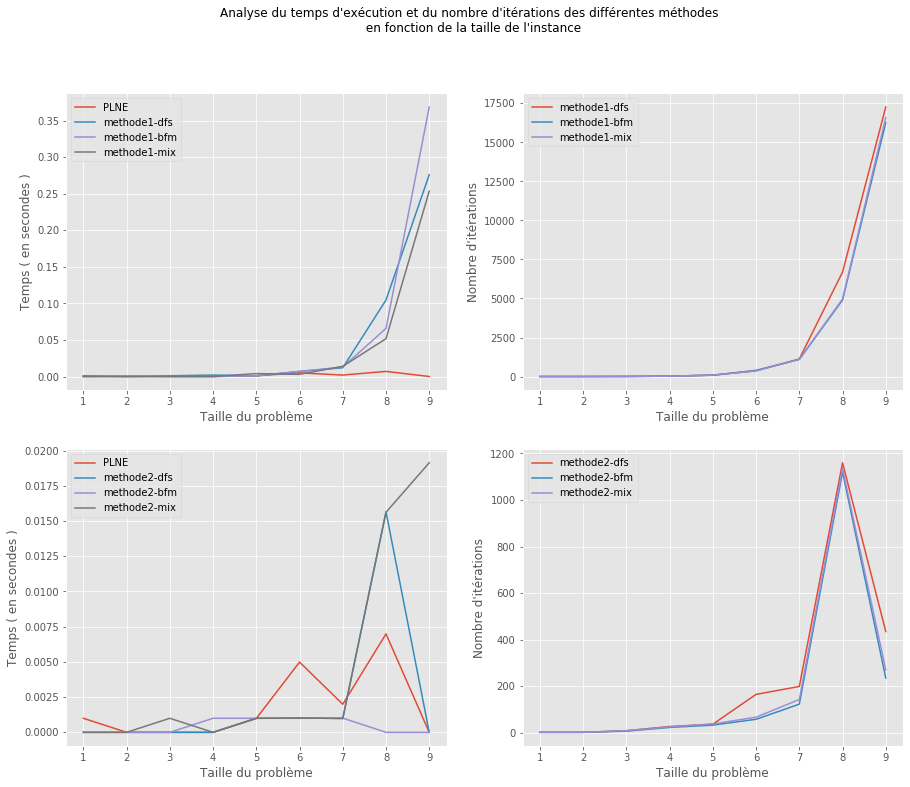

In [46]:
#différentes tailles d'instance pour les tests
val=[i for i in range(1,10)]

#liste pour sauvegarder tps d'execution et nb iterations
t_plne=[] ;t_m1_dfs=[] ; t_m1_bfm=[] ; t_m1_mix=[] ;  t_m2_dfs=[] ; t_m2_bfm=[] ; t_m2_mix=[] 


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Resolution PLNE
    t1_plne = time.time()
    probleme.resolutionPLNE(afficheTout=0)
    t_plne.append(time.time()-t1_plne)
    
    #Méthode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_dfs.append([time.time()-t1_bb1,k1])


    #Méthode 1 avec meilleur d'abord (BFM):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,best_first_method)
    print(" z2 = ",z2,end="")
    t_m1_bfm.append([time.time()-t1_bb2,k2])
    
    #Méthode 1 avec la méthode mixte:
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,mixed_method)
    print(" z3 = ",z3,end="")
    t_m1_mix.append([time.time()-t1_bb3,k3])


    #Méthode 2 avec un parcours en profondeur (DFS):
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,depth_first_method)
    print(" z4 = ",z4,end="")
    t_m2_dfs.append([time.time()-t1_bb4,k4])


    #Méthode 2 avec meilleur d'abord:
    t1_bb5 = time.time()
    z5,x5,k5 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,best_first_method)
    print(" z5 = ",z5,end="")
    t_m2_bfm.append([time.time()-t1_bb5,k5])
    
    #Méthode 2 avec un méthode mixte:
    t1_bb6 = time.time()
    z6,x6,k6 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,mixed_method)
    print(" z6 = ",z6)
    t_m2_mix.append([time.time()-t1_bb6,k6])


#affichage resultats
plt.figure(figsize=(15,12))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations des différentes méthodes \n en fonction de la taille de l'instance")

label=["methode1-dfs","methode1-bfm","methode1-mix"]
plt.subplot(221)
plt.plot(val,t_plne,label="PLNE")
for t,l in zip([t_m1_dfs,t_m1_bfm,t_m1_mix],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(222)
for (t,l) in zip([t_m1_dfs,t_m1_bfm,t_m1_mix],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

label=["methode2-dfs","methode2-bfm","methode2-mix"]
plt.subplot(223)
plt.plot(val,t_plne,label="PLNE")
for t,l in zip([t_m2_dfs,t_m2_bfm,t_m2_mix],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(224)
for (t,l) in zip([t_m2_dfs,t_m2_bfm,t_m2_mix],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()


plt.show()

### d) Nouvelles méthodes pour les bornes primales

Jusqu'ici, nous avons implémenté une méthode naïve pour le calcul de la borne primale initiale qui consistait simplement à prendre la solution réalisable correspondant à l'usinage des pièces dont l'ordre croissant de leurs indices. Selon les instances traités, cette solution peut produire ou non une 'bonne' borne primale initiale (c'est-à-dire une borne qui va permettre d'élaguer très tôt le plus de noeuds possibles).\
Une autre solution consisterait à ranger les pièces dans l'ordre croissant de leur dates limites $d_j$ (leurs deadlines). Par exemple, pour l'exemple présenté en introduction, l'ordre des pièces selon les dates limites croissantes serait : $0$, $2$, $1$ et $3$ et donc la solution réalisable obtenue serait $P_{0,\,2,\, 1,\, 3}$. Cette méthode n'est pas toujours plus avantageuse, notamment sur l'exemple, la méthode 1 utilisée jusqu'ici fournit comme borne primale initiale la valeur de la solution de $P_{0,\,1,\,2,\,3}$ qui est de $115$ tandis que la méthode proposée ici fournit comme borne primale initiale la valeur de $P_{0,\,2,\, 1,\, 3}$ qui n'est que de $136$.\
Nous avons implémenté cette technique dans la fonction primale2 qui prend en paramètre une instance du problème **instance** et qui retourne la valeur de la borne primale (**primale**) ainsi que la solution associée.

In [27]:
def primale2(instance):
    borne = 0
    tuples_indice_deadline = [(i,instance.deadlines[i]) for i in range(instance.nb_piece)]
    tuples_indice_deadline = sorted(tuples_indice_deadline, key=itemgetter(1))
    solution = [tuples_indice_deadline[i][0] for i in range(instance.nb_piece)]
    date_fin = 0
    for i in solution:
        date_fin += instance.unite_temps[i]
        borne += max(0,date_fin - instance.deadlines[i])*instance.penalites[i]
    return(borne, solution)

Cependant cette méthode ci-dessus (ainsi que la première) ne tient pas compte des pénalités de retard des pièces. En effet, ici on ne se base que sur la date limite de chaque pièce mais il est tout à fait possible qu'une pièce est ai une grande deadline $d_j$ tout en ayant une grande valeur de pénalité de retard par unité de temps $\omega_j$ auquel cas cette pièce peut finalement engendré beaucoup de pénalité bien que sa date limite soit tardive. Sur l'exemple de base, la pièce 2 doit être prête avant la pièce 3 (on a $d_2 = 25 < d_3 = 27$) donc si on suit la méthode présenté ci-dessus, on devrait ranger la pièce 2 avant la pièce 3 mais si la pièce 2 passait en dernier, elle n'engendrerait une pénalité que de $\max(0,\sum_{j=0}^3{T_j} - d_2)\times \omega_2 = 57$ tandis que si la pièce 3 passait en dernier, elle engendrerait une pénalité de $\max(0,\sum_{j=0}^3{T_j} - d_3)\times \omega_3 = 85$. Une autre méthode permettant d'obtenir une borne primale initiale consisterait à prendre en compte le retard potentiel que peut engendrer chaque pièce. On crée donc une solution en ajouter succéssivement en dernière position (en partant de la fin) la pièce qui si elle est usiné en dernière position disponible engendre la plus petite pénalité. Reprenons l'exemple donné en introduction, la pièce donnant lieu à la plus petite pénalité de retard en dernière position est la pièce 2 avec une pénalité de $\max(0,\sum_{j=0}^3{T_j} - d_2)\times \omega_2 = 57$. Ensuite la pièce donnant lieu à la plus petite pénalité de retard en avant-dernière position est la pièce 3 avec une péanlité de $\max(0,\sum_{ j\in J\backslash \{2\}  }{T_j} - d_3)\times \omega_3 = 10$ et ainsi de suite. Pour l'exemple considéré on obtient la solution associée à $P_{0,\,1,\,3,\,2}$ dont la valeur est de $67$ (Notons ici que l'on tombe sur la solution optimale de l'instance).

Cette nouvelle méthode de calcul de la borne primale initiale a été implémenté dans la fonction primale3 qui suit le même modèle que les fonctions primale1 et primale2 en prenant en paramètre une instance du problème **instance** et qui retourne la valeur de la borne primale (**primale**) ainsi que la solution associée.

In [28]:
def primale3(instance):
    borne = 0
    piece_non_ajoute = list(range(instance.nb_piece))
    solution = []
    date_fin = sum(instance.unite_temps)
    while(len(piece_non_ajoute) != 0):
        pire_cas = [ max(0,(date_fin - instance.deadlines[i]))*instance.penalites[i] for i in piece_non_ajoute ]
        index = np.argmin(pire_cas)
        borne += pire_cas[index]
        prochaine_piece = piece_non_ajoute.pop(index)
        date_fin -= instance.unite_temps[prochaine_piece]
        solution.insert(0,prochaine_piece)
    return(borne,solution)

Calculons maintenant une borne primale (intiale)sur l'exemple avec les 3 méthodes dont nous disposons maintenant.

In [29]:
object1 = primale1(Exemple)
print("- Méthode primale1 pour l'exemple donné en introduction : ")
print("Borne primale initiale: ",str(object1[0]),", Solution réalisable correspondante: ",str(object1[1]))
object2 = primale2(Exemple)
print("- Méthode primale2 pour l'exemple donné en introduction : ")
print("Borne primale initiale: ",str(object2[0]),", Solution réalisable correspondante: ",str(object2[1]))
object3 = primale3(Exemple)
print("- Méthode primale3 pour l'exemple donné en introduction : ")
print("Borne primale initiale: ",str(object3[0]),", Solution réalisable correspondante: ",str(object3[1]))

- Méthode primale1 pour l'exemple donné en introduction : 
Borne primale initiale:  115 , Solution réalisable correspondante:  [0, 1, 2, 3]
- Méthode primale2 pour l'exemple donné en introduction : 
Borne primale initiale:  136 , Solution réalisable correspondante:  [0, 2, 1, 3]
- Méthode primale3 pour l'exemple donné en introduction : 
Borne primale initiale:  67 , Solution réalisable correspondante:  [0, 1, 3, 2]


On remarque que l'on obtient bien les valeurs et les solutions citées précédemment.

Nous disposons maintenant de 3 méthodes fonctionnelles permettant de calculer une borne primale initiale pour une instance du problème d'ordonnancement. Cependant, il est assez difficile de comparer ces méthode entres elles et d'en dégager une qui serait siginificativement meilleur que les autres. En effet, bien que les fonctions primale2 et primale3 semblent fournir des bornes primales initiales avec des techniques plus élaborées que celle de la fonction primale1, il est tout à fait possible que pour certaines instances la fonction primale1 produise une meilleure borne primale (qui aboutira à un "meilleure" élagage de l'arbre d'énumération) initiale que les 2 autres fonctions (en effet, pour une instance de taille $n$, la solution de $P_{0,\,...,\,n}$ donnée par primale1 peut très bien être une très bonne borne primale proche de la solution du problème).

Dans notre cas, pour mettre en évidence l'impact du choix de la borne primale initiale sur l'éxecution de l'algorithme de Branch-and-bound, nous allons utiliser les 2 fonctions suivantes permettant de produire des bornes primales initiales.

In [30]:
#Fonction renvoyant la pire borne primale (la plus grande) parmi primale1, primale2 et primale3 pour une instance donnee
def primale_worst(instance):
    tuple_primale =(primale1(instance),primale2(instance),primale3(instance))
    best_primale = max(tuple_primale)
    return(best_primale[0],best_primale[1])

#Fonction renvoyant la meilleure borne primale (la plus petite) parmi primale1, primale2 et primale3 pour une instance donnee
def primale_best(instance):
    tuple_primale =(primale1(instance),primale2(instance),primale3(instance))
    best_primale = min(tuple_primale)
    return(best_primale[0],best_primale[1])

La première fonction renvoie la plus grande borne primale calculée par primale1, primale2 et primale3 pour une instance donnée tandis que la deuxième fonction renvoie la plus petite borne primale calculée par primale1, primale2 et primale3 toujours pour une instance donnée.

Sur des instances aléatoires de taille croissante, nous allons comparer pour différentes méthodes implémentées précédemment l'éxecution de l'algorithme de Branch-and-Bound lorsqu'il est initialisé avec la pire borne primale des 3 fonctions (primale1, primale2 et primale3) et lorsqu'il est initialisé avec la meilleure borne primale des 3 fonctions. Nous nous attendons à ce que ceci mette en évidence le fait qu'une mauvaise borne (trop grande) puisse dans certaines cas engendrer des temps d'éxecution beaucoup plus longs. 

Nous avons constaté précédement que l'utilisation d'un parcours en largeur comme méthode d'exploration pouvait engendrer des temps d'éxecution très longs et nous avons supposé que ceci provenait du fait que la borne primale initiale était de mauvaise qualtié. Comparons donc l'éxecution de l'algorithme de Branch-and-bound pour la méthode 1 avec un parcours en largeur en guise de méthode d'exploration dans le cas où l'algorithme est systématiquement initialisé avec la pire borne primale des 3 fonctions et dans le cas où il est systématiquement initialisé avec la meilleure borne primale des 3 fonctions (pour des instances dont la taille varie entre $n=1$ et $n=8$).

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  7 z2 =  7
taille instance =  3 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  4 test égalite valeur optimale :  z1 =  9 z2 =  9
taille instance =  5 test égalite valeur optimale :  z1 =  500 z2 =  500
taille instance =  6 test égalite valeur optimale :  z1 =  218 z2 =  218
taille instance =  7 test égalite valeur optimale :  z1 =  496 z2 =  496
taille instance =  8 test égalite valeur optimale :  z1 =  386 z2 =  386


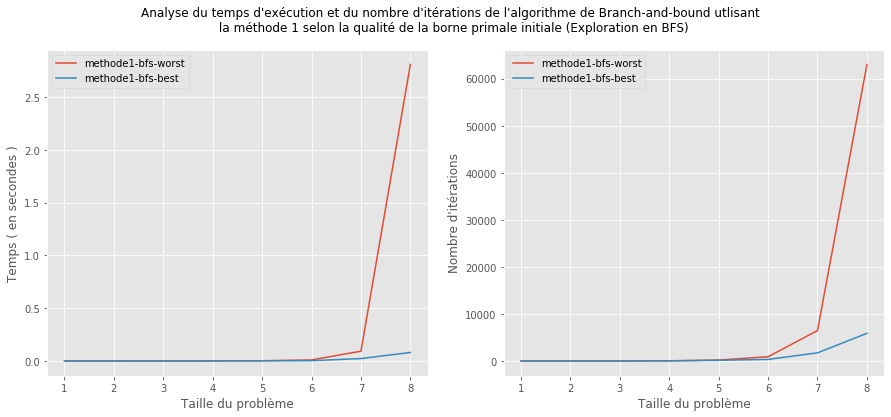

In [31]:
#Avec la méthode 1 (BFS)
val=[i for i in range(1,9)]

t_m1_bfs_best = [] ; t_m1_bfs_worst = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 1 avec un parcours en largeur (BFS) pour la "pire" méthode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale1,Branchement1,breadth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_bfs_worst.append([time.time()-t1_bb2,k1])
    
    #Méthode 1 avec un parcours en largeur (BFS) pour la "meilleure" méthode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,breadth_first_method)
    print(" z2 = ",z2,end="")
    t_m1_bfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 1 selon la qualité de la borne primale initiale (Exploration en BFS)")
label=["methode1-bfs-worst","methode1-bfs-best"]
plt.subplot(121)
for t,l in zip([t_m1_bfs_worst,t_m1_bfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m1_bfs_worst,t_m1_bfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()   

Faisons de même en utilisant toujours un parcours en largeur mais cette fois-ci avec la méthode 2.

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  4 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  5 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  6 test égalite valeur optimale :  z1 =  259 z2 =  259
taille instance =  7 test égalite valeur optimale :  z1 =  232 z2 =  232
taille instance =  8 test égalite valeur optimale :  z1 =  126 z2 =  126


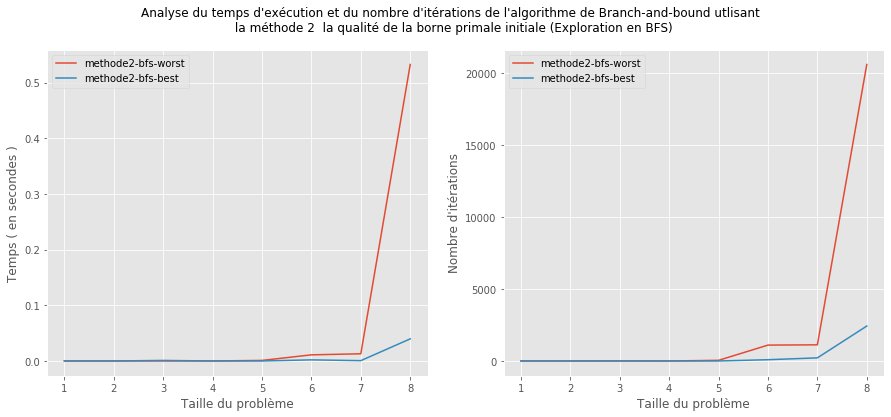

In [32]:
#Avec la méthode 2 (BFS)
val=[i for i in range(1,9)]

t_m2_bfs_worst = [] ; t_m2_bfs_best = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 2 avec un parcours en largeur (BFS) pour la "pire" méthode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale2,Branchement2,breadth_first_method)
    print(" z1 = ",z1,end="")
    t_m2_bfs_worst.append([time.time()-t1_bb2,k1])
    
    #Méthode 2 avec un parcours en largeur (BFS) pour la "meilleure" méthode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,breadth_first_method)
    print(" z2 = ",z2,end="")
    t_m2_bfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 2  la qualité de la borne primale initiale (Exploration en BFS)")

label=["methode2-bfs-worst","methode2-bfs-best"]
plt.subplot(121)
for t,l in zip([t_m2_bfs_worst,t_m2_bfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m2_bfs_worst,t_m2_bfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()   

Sur les 2 jeux de graphiques obtenus en sortie, on peut observer que lorsque la taille de l'instance augmente, le temps d'éxecution et le nombre d'itérations de l'algorithme de Branch-and-bound augmente plus fortement lorsqu'il est initialisé systématiquement avec la "pire" borne primale que lorsqu'il est initialisé avec la "meilleure" borne primale. Ceci met donc en évidence le fait que le choix de la borne primale initiale peut être déterminant dans la poursuite de l'exécution de l'algorithme de Branch-and-bound lorsqu'il utilise une méthode de parcours en largeurs pour visiter les noeuds de l'arbre.

Regardons maintenant ce qu'il en est lorsque l'on utilise cette fois-ci une méthode de parcours en profondeur pour explorer les noeuds de l'arbre. De la même manière, on compare l'éxecution de l'algorithme de Branch-and-bound pour la méthode 1 et pour la méthode 2 avec un parcours en profondeur en guise de méthode d'exploration dans le cas où l'algorithme est systématiquement initialisé avec la pire borne primale des 3 fonctions et dans le cas où il est systématiquement initialisé avec la meilleure borne primale des 3 fonctions (toujours pour des instances dont la taille varie entre $n=1$ et $n=8$).

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  4 test égalite valeur optimale :  z1 =  21 z2 =  21
taille instance =  5 test égalite valeur optimale :  z1 =  38 z2 =  38
taille instance =  6 test égalite valeur optimale :  z1 =  394 z2 =  394
taille instance =  7 test égalite valeur optimale :  z1 =  40 z2 =  40
taille instance =  8 test égalite valeur optimale :  z1 =  238 z2 =  238


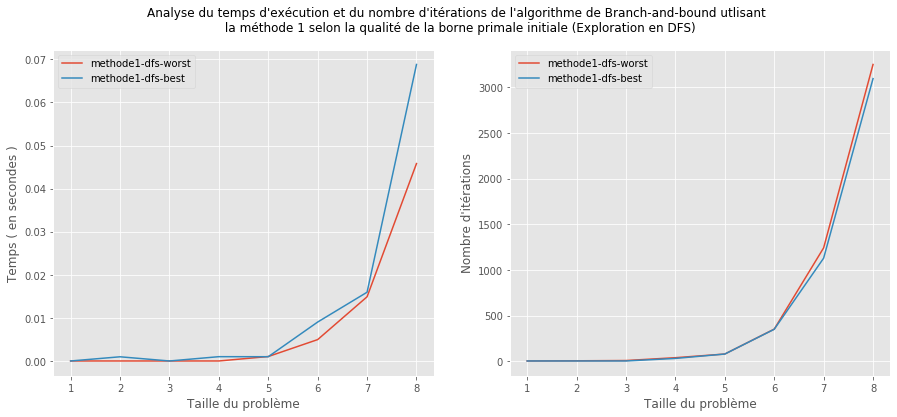

In [33]:
#Avec la méthode 1 (DFS)
val=[i for i in range(1,9)]

t_m1_dfs_worst = [] ; t_m1_dfs_best = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 1 avec un parcours en largeur (BFS) pour la "pire" méthode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale1,Branchement1,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_dfs_worst.append([time.time()-t1_bb2,k1])
    
    #Méthode 1 avec un parcours en largeur (BFS) pour la "meilleure" méthode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,depth_first_method)
    print(" z2 = ",z2,end="")
    t_m1_dfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 1 selon la qualité de la borne primale initiale (Exploration en DFS)")

label=["methode1-dfs-worst","methode1-dfs-best"]
plt.subplot(121)
for t,l in zip([t_m1_dfs_worst,t_m1_dfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m1_dfs_worst,t_m1_dfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()   

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  30 z2 =  30
taille instance =  4 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  5 test égalite valeur optimale :  z1 =  261 z2 =  261
taille instance =  6 test égalite valeur optimale :  z1 =  348 z2 =  348
taille instance =  7 test égalite valeur optimale :  z1 =  83 z2 =  83
taille instance =  8 test égalite valeur optimale :  z1 =  445 z2 =  445


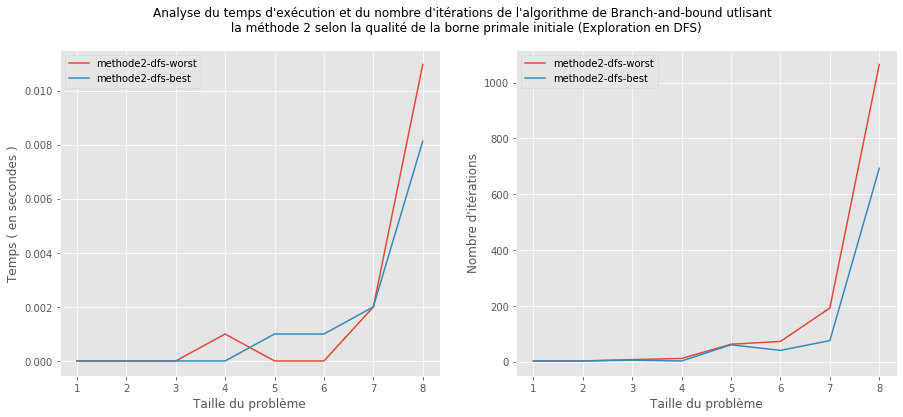

In [34]:
#Avec la méthode 2 (DFS)
val=[i for i in range(1,9)]

t_m2_dfs_worst = [] ; t_m2_dfs_best = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 2 avec un parcours en largeur (BFS) pour la "pire" méthode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale2,Branchement2,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m2_dfs_worst.append([time.time()-t1_bb2,k1])
    
    #Méthode 2 avec un parcours en largeur (BFS) pour la "meilleure" méthode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,depth_first_method)
    print(" z2 = ",z2,end="")
    t_m2_dfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 2 selon la qualité de la borne primale initiale (Exploration en DFS)")

label=["methode2-dfs-worst","methode2-dfs-best"]
plt.subplot(121)
for t,l in zip([t_m2_dfs_worst,t_m2_dfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m2_dfs_worst,t_m2_dfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()  

On remarque cette fois-ci sur les 2 jeux de graphique précédents que l'impact de la qualité de la borne primale initiale est moins élevé sur le temps d'éxecution et sur le nombre d'itération de l'algorithme de Branch-and-bound utilise en guise de méthode d'exploration un parcours en profondeur de l'arbre d'énumération. En effet, l'utilisation d'un parcours en profondeur permet d'atteindre plus tôt les noeuds feuilles de l'arbre d'énumération et donc la brone primale (qu'elle soit "bonne" ou "mauvaise") sera mise-à-jour très tôt dans l'éxecution de l'algorithme. On illustre bien ici le fait que l'exploration de l'arbre d'énumération par un parcours en profondeur permet de trouver rapidement une "bonne" borne primale. 

### e) Analyse des résultats

## IV - Visualisation du parcours de l'arbre de branchement lors de l'exécution de l'algorithme de Branch-And-Bound

## V - Ajout de contraintes de précédence sur les pièces au problème d'ordonnancement 

Nous avons jusqu'ici considéré une version du problème d'ordonnancement dans laquelle les pièces peuvent être usinées dans n'importe qu'elle ordre (on cherche juste le meilleur ordre possible soit celui engendrant le moins de pénalités) mais on peut aussi considérer des contraintes de précédence du type : la pièce $i$ doit être usinée avant la pièce $j$ pour $i,j\in J$ tel que $i\neq j$.

Pour traité, cette configuration, comme nous l'avons dit plus haut, la classe Ordonnancement a été adaptée à cette extension du problème initiale. Elle possède en effet un attribut permettant de stocker des contraintes de précédence sous la forme d'un tableau associatif donnant pour chaque pièce en entré, une liste de pièces qui doivent être usinées avant celle-ci. Elle dispose également d'une méthode permettant d'ajouter des contraintes de précédence.

Nous avons par ailleurs adapté le programme linéaire en nombre entier permettant de résoudre le problème initiale en lui ajouter des contraintes permettant d'assurer les contraintes de précédence. On peut remarque que imposer que la pièce $i$ doit passer avant $j$ revient à imposer $x_{i,j} = 1$. On note désormais $\{pred(j)\}_{j\in J}$ l'ensemble constitué d'une liste pour chaque pièce $j\in J$ contenant les pièces qui doivent passer avant la pièce $j$ (Si aucune pièce n'est contrainte de passer avant $j$ alors $\{pred(j)\}_{j\in J} = \emptyset$. Il faut en revanche faire attention à ne pas rendre le problème non-réalisable en ajoutant des contraintes de précédence, par exemples, on ne pas peut imposer que la pièce $i$ doit passer avant la pièce $j$ et en même temps que la pièce $j$ doit passer avant la pièce $i$.

La nouvelle version du PLNE est la suivante:

**Variables:**

 * $\forall j \in J, r_j \ge 0$ est une variable réelle positive représentant le retard en unité de temps de la pièce $j$
 
 * $\forall j \in J, f_j \ge 0$ est une variable réelle positive représentant la date de fin d'usinage de la pièce $j$
 
 * $\forall (i,j)\in J^2$, $x_{i,j} \in \{0,1\}$ est une variable binaire prenant la valeur $1$ si la pièce $i$ passe avant la pièce $j$ et $0$ sinon

**Objectif:**

* On cherche à minimiser les pénalités de retard :

$$ \min{\sum_{j\in J}{\omega_j r_j}}$$

**Contraintes:**

* On impose la contrainte suivante pour calculer le retard de chaque pièce :
$$ r_j \ge f_j - d_j,\quad \forall j \in J$$

* On impose la contrainte suivatne pour calculer la date de fin d'usinage de chaque pièce :
$$ f_j = T_j + \sum_{i \in J \\ i\neq j}{T_i x_{ij}} \quad \forall j \in J$$

* On impose une relation d'ordre total sur le passage des pièces :
$$ x_{ij} + x_{ji} = 1 \quad \forall (i,j) \in J^2, \: i < j$$
$$ x_{ik} \ge x_{ij} + x_{jk}-1\quad \forall (i,j,k) \in J^3, \: i<j, \: i<k, j\neq k$$

* On impose enfin les contraintes de précédence entre les pièces :
$$ x_{ij} = 1 \quad \forall j \in J, \: \forall i \in pred(j) $$

On peut noter que "nouvelle" version du PLNE reste très générique puisqu'elle coïncide directement avec la version précédence lorsqu'il n'y a pas de contraintes de précédence, c'est-à-dire lorsque $\forall j \in J, \: pred(j) =\emptyset$ (dans ce cas on impose à aucune variable $x_{ij}$ d'être égale à 1 et on retombe bien sur le problème d'ordonnancement simple). C'est d'ailleurs directement cette version générique du PLNE que nous avons implémenté dans la classe ordonnancement. 

Essayer d'appliquer quelques contraintes de précédence sur l'exemple basique donné en introduction :

In [35]:
Exemple_precedence = Ordonnancement()
P = [4,5,3,5] #Pénalités
T = [12,8,15,9] #Unités de temps nécessaires
D = [16,26,25,27] #Deadlines
Exemple_precedence.ajouterPieces(T,D,P)
Exemple_precedence.afficherProbleme()
Exemple_precedence.resolutionPLNE()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
Pas de contraintes de précédence

SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]


Lorsque l'on ajoute aucune contrainte de précédence, on retombe simplement sur le problème d'ordonnancement précédent dont la valeur optimale est de $67$. Essayons maintenant d'ajouter une contrainte imposant que les pièces 0, 2 et 3 doivent passer avant la pièce 1.

In [36]:
Exemple_precedence.ajouterContraintePrecedence(1,[0,2,3])
Exemple_precedence.afficherProbleme()
Exemple_precedence.resolutionPLNE()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
La pièce 0 doit passer avant la pièce 1
La pièce 2 doit passer avant la pièce 1
La pièce 3 doit passer avant la pièce 1

SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 123.0
Ordre d'usinage des pièces: [0, 3, 2, 1]


On note que la valeur optimale et la solution au problème ont changé et la valeur optimale du nouveau problème est en particulier plus grande que celle du problème initiale (Il s'agit en fait d'une restriction du problème précédent). On remarque bien sûr que la solution obtenue respecte bien les contraines de précédence imposées. Essayons maintenant d'imposer les 2 contraintes suivantes : la pièce 1 doit passer avant la pièce 0 et la pièce 0 doit passer avant la pièce 1.

In [37]:
Exemple_precedence.ajouterContraintePrecedence(1,[0])
Exemple_precedence.ajouterContraintePrecedence(0,[1])
Exemple_precedence.afficherProbleme()
Exemple_precedence.resolutionPLNE()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
La pièce 0 doit passer avant la pièce 1
La pièce 2 doit passer avant la pièce 1
La pièce 3 doit passer avant la pièce 1
La pièce 0 doit passer avant la pièce 1
La pièce 1 doit passer avant la pièce 0

SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Infeasible
Erreur lors de la résolution


On obtient ainsi comme c'était attendu une instance non-réalisable du probleme d'ordonnancement. 

Regardons maintenant ce qu'il en est dans l'arbre d'énumération de l'algorithme de Branch-and-Bound lorsque l'on prend en compte ces nouvelles contraintes. D'abord, avec la méthode de branchement 1, on peut remarquer certains noeuds de l'arbre correspondent à des problèmes non-réalisables. De plus, tous les noeuds fils qui descendent de ces noeuds en questions seront également non-réalisables. Considérons une instance composée de 3 pièces $0$, $1$ et $2$ et on impose que la pièce $2$ doit passer avant la pièce $1$. On observe par exemple au niveau $k=2$ que le noeud $P_{1,\,2, \,.}$ ne respcte pas la contrainte de précédence et que son unique noeud fils $P_{1,\,2,\,0}$ ne l'a respecte pas non plus. On peut donc directement élaguer ce noeud et son descendant (De même, les noeuds solution $P_{0,\,1,\,2}$ et $P_{1,\,0,\,2}$ ne respectent pas non plus cette contraintes). 

![image.png](GrapheDebutPrecedence.PNG)

Ainsi, avec la méthode 1, on peut en parcourant l'arbre d'énumération élaguer des noeuds et leurs descendants si ils ne respectent pas les contraintes de précédence. Dans la règle de branchement, supposons que l'on veut créer un nouveau noeud $N$ en ajoutant la pièce $j$ au noeud père qui contient un ensemble de pièces $J'$. On peut vérifier que celui-ci respecte ou non les contraintes de précédence en regardant si toutes les pièces $i$ devant passer avant $j$ se trouvent dans la liste de pièces $J'$ du noeud père car si ce n'est pas le cas, cela signifie qu'elles seront ajoutées plus tard dans les noeuds descendants de $N$ et qu'elles se retrouveront donc après la pièce $j$ (non-respect de la contrainte de précédence !).

Si on reprend l'arbre ci-dessus, cela signifie que dés le niveau $k=1$, on pouvait prévoir que le noeud $P_{1,\,.,\,.}$ n'allait pas pouvoir engendré de solutions réalisables puisqu'on lui a ajouté la pièce 1 sans qu'il ne contienne la pièce 2 (on rappelle que la pièce 2 doit apparaître avant la pièce 1).

![image.png](GrapheDebutPrecedence2.PNG)

On implémente donc cette procédure dans la fonction Branchement1_pred. Comme pour les méthodes de branchement précédentes, celle-ci prend en paramètre l'**arbre** d'énumération, **l'instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds et elle retourne la liste des noeuds crées (**new_node**).

In [38]:
def Branchement1_pred(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        #Avant de créer un nouveau noeud, on verifie qu'il respecte les contraintes de precedence
        if(i in instance.contraintesPrecedence):
            if(not all(piece in noeud.info for piece in instance.contraintesPrecedence[i])):
                continue
        new_info = noeud.info.copy()
        new_info.append(i)
        des = "P"
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
    #nous retournons la liste des nouveaux noeuds
    return new_node

De la même manière, avec la méthode 2, on peut remarquer que certains noeuds ne sont pas réalisables. Reprenons l'exemple contenant 3 pièces : $0$, $1$ et $2$ avec la contrainte que $2$ doit passer avant la pièce $1$. L'arbre d'énumération associé à la méthode 2 est représenté ci-dessous. Sur ce dernier, on remarque qu'au niveau $k=2$ que le noeud $P_{.,\,1, \,2}$ et son unique noeud fils ne respecte pas la contrainte de précédence (idem pour les noeuds solutions $P_{1,\,0, \,2}$ et $P_{1,\,2, \,0}$). De manière analogue à la méhtode 1, on peut aussi élaguer des neouds dans l'arbre ainsi que leurs descendants.

![image.png](GrapheFinPrecedence.PNG)

Dans la règle de branchement associée à la méthode 2, supposons que l'on veut créer un nouveau noeud $N$ en ajoutant en dernière position disponible la pièce $j$ au noeud père qui contient un ensemble de pièces $J'$ (cette fois-ci en partant de la fin). On peut vérifier que celui-ci respecte ou non les contraintes de précédence en regardant si toutes les pièces $i$ devant passer avant $j$ ne se trouvent pas dans la liste de pièces $J'$ du noeud père car si ce n'est pas le cas, cela signifie qu'elles seront usinées après $j$ (non-respect de la contrainte de précédence !).

De la même manière, on peut coder cette nouvelle procédure dans fonction Branchement2_pred qui, sur le même modèle que les autres fonctions Branchement prend en paramètre l'**arbre** d'énumération, **l'instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds. Cette fonction retourne également la liste des noeuds crées (**new_node**).

In [39]:
def Branchement2_pred(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        #Avant de créer un nouveau noeud on s'assure qu'il respecte bien les contraintes de precedence
        if(i in instance.contraintesPrecedence):
            if(any(piece in noeud.info for piece in instance.contraintesPrecedence[i])):
                continue
        new_info = noeud.info.copy()
        new_info.insert(0,i)
        #Si il s'agit d'un noeud fils, on s'assure qu'il reste toujours réalisable en ajoutant les dernières pièces
        if(position):
            derniere_piece = [x for x in range(instance.nb_piece) if x not in new_info]
            if(derniere_piece[0] in instance.contraintesPrecedence):
                if(any(piece in noeud.info for piece in instance.contraintesPrecedence[derniere_piece[0]])):
                    continue
        des = "P"
        for piece in pieces_non_usinees:
            des += "."
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
    #nous retournons la liste des nouveaux noeuds
    return new_node

Notons que pour traiter cette extension du problème d'ordonnancement, nous n'avons eu besoin que d'adapter nos méthodes de branchement. Le reste des fonctionnalités de l'algorithme de Branch-and-bound reste globalement inchangé, particulier les méthodes d'exploration des noeuds et les méthodes de calcul des bornes duales. Cependant, certaines méthode permettant de calculer des bornes primales initiales ne sont ici plus valides car les solutions qu'elles renvoient ne respectent pas forcément les contraintes de précédence. Notons également que ces nouvelles implémentation des méthodes de branchement sont génériques et qu'elles s'adaptent parfaitement au cas où il n'y a pas de contraintes d'ordonnancement dans le problème (on retombe ainsi sur le problème d'ordonnancement initial).

Pour obtenir une borne primale initiale, on peut chercher à claculer une borne supérieure à toutes les solutions possibles du problème d'ordonnancement (avec ou sans contraintes de précédence). On peut remarquer que pour une instance donnée, pour toute pièce $j\in J$, que le plus grand retard possible que pourra engendré cette pièce correspond au cas où elle passera en dernière position, c'est-à-dire:
$$\forall j\in J, \quad r_j \le \max{(0,\sum_{i\in J}{T_i - d_j})}$$
On en déduit ainsi une borne supérieure sur la valeur de la fonction obectif:
$$\sum_{j\in J}{\omega_j r_j} \le \sum_{j\in J}{\omega_j \max{(0,\sum_{i\in J}{T_i - d_j})}}$$
La fonction primale4 permet de calculer une borne primale initiale pour une instance du problème donné (avec ou sans contrainte de précédence) à partir de cette méthode. Elle prend en paramètre une **instance** du problème et retourne en sortie la valeur de la borne primale initiale ainsi qu'une solution vide (Cette solution sera forcément mise-à-jour plus tard lors de l'exécution de l'algorithme de Branch-and-bound puisque cette borne primale initiale est supérieure aux valeurs objectives de toutes les solutions réalisables). 

In [40]:
def primale4(instance):
    borne = 0
    date_fin = sum(instance.unite_temps)
    for i in range(instance.nb_piece):
        borne += max(0,date_fin - instance.deadlines[i])*instance.penalites[i]
    return(borne,[])

Nous allons maintenant réaliser quelques test pour une instance aléatoire du problème contenant 7 pièces ($J = \{0,...,6\}$) et en imposant que toutes les pièces doivent passer avant la pièce $0$. L'instance du problème crée sera d'abord résolue avec le modèle PLNE afin de vérifier la validité du résultat puis nous tester chacune des 2 méthodes de branchement pour notre algorithme de Branch-and-bound (on testera aussi plusieurs méthodes de parcours de l'arbre d'énumération).

In [41]:
#Taille du problème
n = 8
#Création de l'instance alétoire de taille n
probleme = Ordonnancement()
probleme.problemeAleatoire(8)
#On impose que toutes les pièces passent avant la pièce 0
probleme.ajouterContraintePrecedence(0,list(range(1,n)))

#Résolution PLNE:
t1_plne = time.time()
probleme.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")


#Méthode 1 avec parcours en profondeur (BFS)
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,depth_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (DFS) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)


#Méthode 1 avec un parcours en largeur (BFS):
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,breadth_first_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (BFS) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)


#Méthode 1 avec 'meilleur d'abord':
t1_bb3 = time.time()
z3,x3,k3 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,best_first_method)
t2_bb3 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (Meilleur d'abord) : \n\nz = ",z3,", x = ",x3)
print("Temps exécution B&B: ",t2_bb3-t1_bb3,"s")
print("Nombre d'itérations: ",k3)


#Méthode 1 avec la méthode mixte:
t1_bb4 = time.time()
z4,x4,k4 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,mixed_method)
t2_bb4 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (Mixte) : \n\nz = ",z4,", x = ",x4)
print("Temps exécution B&B: ",t2_bb4-t1_bb4,"s")
print("Nombre d'itérations: ",k4)


#Méthode 2 avec un parcours en profondeur (DFS):
t1_bb5 = time.time()
z5,x5,k5 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,depth_first_method)
t2_bb5 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (DFS) : \n\nz = ",z5,", x = ",x5)
print("Temps exécution B&B: ",t2_bb5-t1_bb5,"s")
print("Nombre d'itérations: ",k5)


#Méthode 2 avec un parcours en largeur (BFS):
t1_bb6 = time.time()
z6,x6,k6 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,breadth_first_method)
t2_bb6 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (BFS) : \n\nz = ",z6,", x = ",x6)
print("Temps exécution B&B: ",t2_bb6-t1_bb6,"s")
print("Nombre d'itérations: ",k6)


#Méthode 2 avec 'meilleur d'abord':
t1_bb7 = time.time()
z7,x7,k7 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,best_first_method)
t2_bb7 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (Meilleur d'abord) : \n\nz = ",z7,", x = ",x7)
print("Temps exécution B&B: ",t2_bb7-t1_bb7,"s")
print("Nombre d'itérations: ",k7)

#Méthode 2 avec la méthode mixte:
t1_bb8 = time.time()
z8,x8,k8 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,mixed_method)
t2_bb8 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (Mixte) : \n\nz = ",z8,", x = ",x8)
print("Temps exécution B&B: ",t2_bb8-t1_bb8,"s")
print("Nombre d'itérations: ",k8)


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 1275.0
Ordre d'usinage des pièces: [5, 2, 7, 4, 3, 1, 6, 0]
Temps exécution pulp:  0.39211416244506836 s


SOLUTION OBTENUE B&B METHODE 1 (DFS) : 

z =  1275 , x =  [7, 5, 2, 4, 3, 1, 6, 0]
Temps exécution B&B:  0.08498644828796387 s
Nombre d'itérations:  5435


SOLUTION OBTENUE B&B METHODE 1 (BFS) : 

z =  1275 , x =  [7, 5, 2, 4, 3, 1, 6, 0]
Temps exécution B&B:  0.3686177730560303 s
Nombre d'itérations:  13701


SOLUTION OBTENUE B&B METHODE 1 (Meilleur d'abord) : 

z =  1275 , x =  [2, 5, 7, 4, 3, 1, 6, 0]
Temps exécution B&B:  0.08280396461486816 s
Nombre d'itérations:  5411


SOLUTION OBTENUE B&B METHODE 1 (Mixte) : 

z =  1275 , x =  [7, 5, 2, 4, 3, 1, 6, 0]
Temps exécution B&B:  0.08370089530944824 s
Nombre d'itérations:  5435


SOLUTION OBTENUE B&B METHODE 2 (DFS) : 

z =  1275 , x =  [2, 5, 7, 4, 3, 1, 6, 0]
Temps exécution B&B:  0.15088105201721191 s
Nombre d'itérations:  9008


SOLUTION OBTENUE B&B

On remarque que sur tous les tests réalisés ci-dessus, on trouve la même valeur objectif que le PLNE. De plus, on remarque que dans les solutions proposées, la pièce 0 est bien usinée en dernière position comme c'était attendu. Ceci confirme donc le bon fonctionnement de nos nouvelles méthodes de branchement adapté à la restriction du problème d'ordonnancement implémentant des contraintes de précédence.

Nous avons mis en évidence plus haut que le fait d'ajouter des contraintes de précédence au problème d'ordonnancement élaguait très vite une partie des arbres et diminuait ainsi le nombre de noeuds parcourus par l'algorithme. En ajoutant des contraintes de précédence sur l'ordre de passage des pièces, on réduit le nombre de solutions possibles au problème d'ordonnancement initiale (c'est une restriction du problème initiale).

Essayons de vérifier numériquement que l'algorithme parcours moins de noeuds dans l'arbre lorsqu'il y a des contraintes de précédence. Pour cela, on génére des instances aléatoires de taille croissante (pour $n$ allant de 3 à 8) et on résout (avec les différentes méthodes que nous avons présenté jusqu'ici) le même problème sans aucune contraintes de précédence puis après avoir ajouté des contraintes de précédences et ceci pour les méthode 1 et 2. Pour chaque problème de taille $n\in \{4,...,9\}$, on imposera comme contrainte de précédence que les pièces 0 et 1 passent en dernieres positions après toutes les autres pièces et que les pièce $n-1$ et $n-2$ passent en premières positions avant toutes les autres.Voici les résultats obtenus pour la méthode 1 puis la méthode 2.

Traitement problème taille: 4
Traitement problème taille: 5
Traitement problème taille: 6
Traitement problème taille: 7
Traitement problème taille: 8
Traitement problème taille: 9


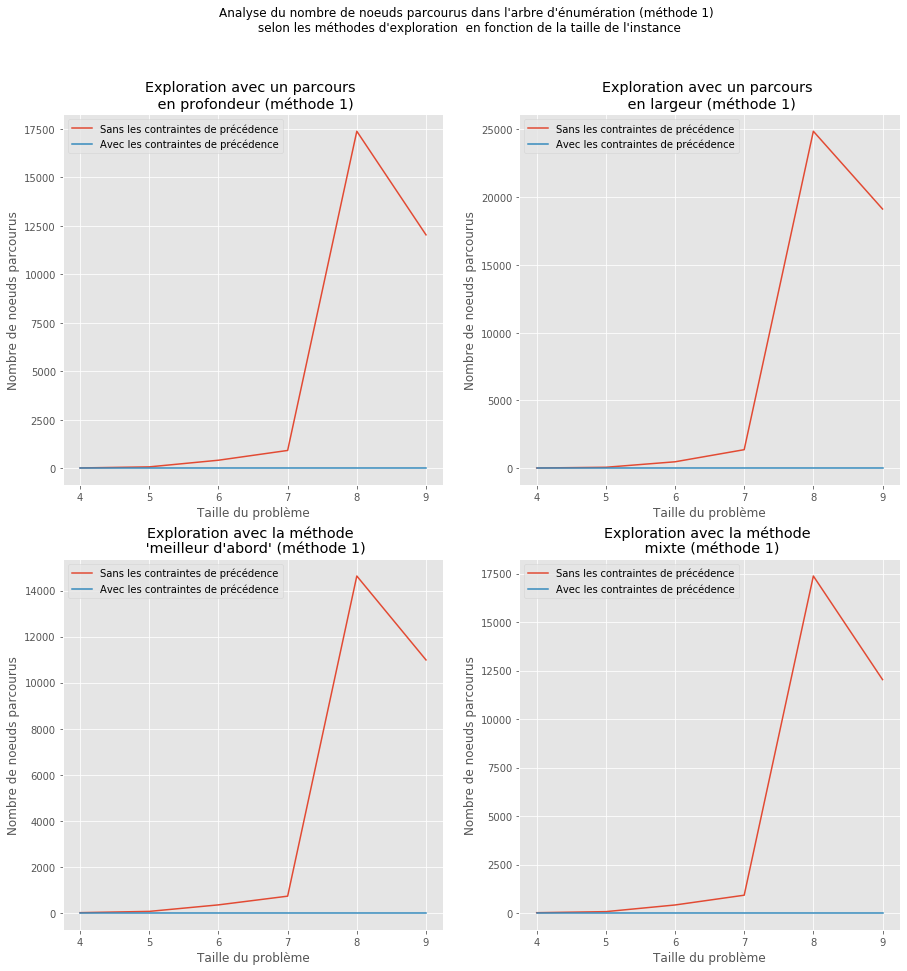

In [110]:
#différentes tailles d'instance pour les tests
val=[i for i in range(4,10)]

#liste pour sauvegarder tps d'execution et nb iterations:
#Sans contraintes de précédence
t_m1_dfs = [] ; t_m1_bfs = [] ; t_m1_best = [] ; t_m1_mixed = []
#Avec contraintes de précédence
t_m1_dfs_pred = [] ; t_m1_bfs_pred = [] ; t_m1_best_pred = [] ; t_m1_mixed_pred = []


for n in val:
    print("Traitement problème taille:",n)
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,depth_first_method)
    t_m1_dfs.append([time.time()-t1_bb1,k1])


    #Méthode 1 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,breadth_first_method)
    t_m1_bfs.append([time.time()-t1_bb2,k2])


    #Méthode 1 avec la méthode "meilleur d'abord":
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,best_first_method)
    t_m1_best.append([time.time()-t1_bb3,k3])


    #Méthode 1 avec la méthode "mixte":
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,mixed_method)
    t_m1_mixed.append([time.time()-t1_bb4,k4])
    
    #Ajout d'une contrainte de précédence: la pièce 0 doit passer en dernier
    probleme.ajouterContraintePrecedence(0,list(range(2,n)))
    probleme.ajouterContraintePrecedence(1,list(range(2,n)))
    for p in range(2,n-1):
        probleme.ajouterContraintePrecedence(p,[n-2,n-1])
    
    #Méthode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1_pred,depth_first_method)
    t_m1_dfs_pred.append([time.time()-t1_bb1,k1])


    #Méthode 1 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1_pred,breadth_first_method)
    t_m1_bfs_pred.append([time.time()-t1_bb2,k2])


    #Méthode 1 avec la méthode "meilleur d'abord":
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1_pred,best_first_method)
    t_m1_best_pred.append([time.time()-t1_bb3,k3])


    #Méthode 1 avec la méthode "mixte":
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1_pred,mixed_method)
    t_m1_mixed_pred.append([time.time()-t1_bb4,k4])

#affichage resultats
fig, axs = plt.subplots(2,2,figsize=(15, 15))
plt.suptitle("Analyse du nombre de noeuds parcourus dans l'arbre d'énumération (méthode 1) \n selon les méthodes d'exploration  en fonction de la taille de l'instance")

label=["Sans les contraintes de précédence","Avec les contraintes de précédence"]

axs[0,0].set_title("Exploration avec un parcours \n en profondeur (méthode 1)")
for (t,l) in zip([t_m1_dfs,t_m1_dfs_pred],label):
    axs[0,0].plot(val,[z[1] for z in t],label=l)
axs[0,0].set_ylabel("Nombre de noeuds parcourus")
axs[0,0].set_xlabel("Taille du problème")
axs[0,0].legend()
    
axs[0,1].set_title("Exploration avec un parcours \n en largeur (méthode 1)")
for (t,l) in zip([t_m1_bfs,t_m1_bfs_pred],label):
    axs[0,1].plot(val,[z[1] for z in t],label=l)
axs[0,1].set_ylabel("Nombre de noeuds parcourus")
axs[0,1].set_xlabel("Taille du problème")
axs[0,1].legend()

axs[1,0].set_title("Exploration avec la méthode \n 'meilleur d'abord' (méthode 1)")
for (t,l) in zip([t_m1_best,t_m1_best_pred],label):
    axs[1,0].plot(val,[z[1] for z in t],label=l)
axs[1,0].set_ylabel("Nombre de noeuds parcourus")
axs[1,0].set_xlabel("Taille du problème")
axs[1,0].legend()
    
axs[1,1].set_title("Exploration avec la méthode \n mixte (méthode 1)")
for (t,l) in zip([t_m1_mixed,t_m1_mixed_pred],label):
    axs[1,1].plot(val,[z[1] for z in t],label=l)
axs[1,1].set_ylabel("Nombre de noeuds parcourus")
axs[1,1].set_xlabel("Taille du problème")
axs[1,1].legend()

plt.show()

Traitement problème taille: 3
Traitement problème taille: 4
Traitement problème taille: 5
Traitement problème taille: 6
Traitement problème taille: 7
Traitement problème taille: 8
Traitement problème taille: 9


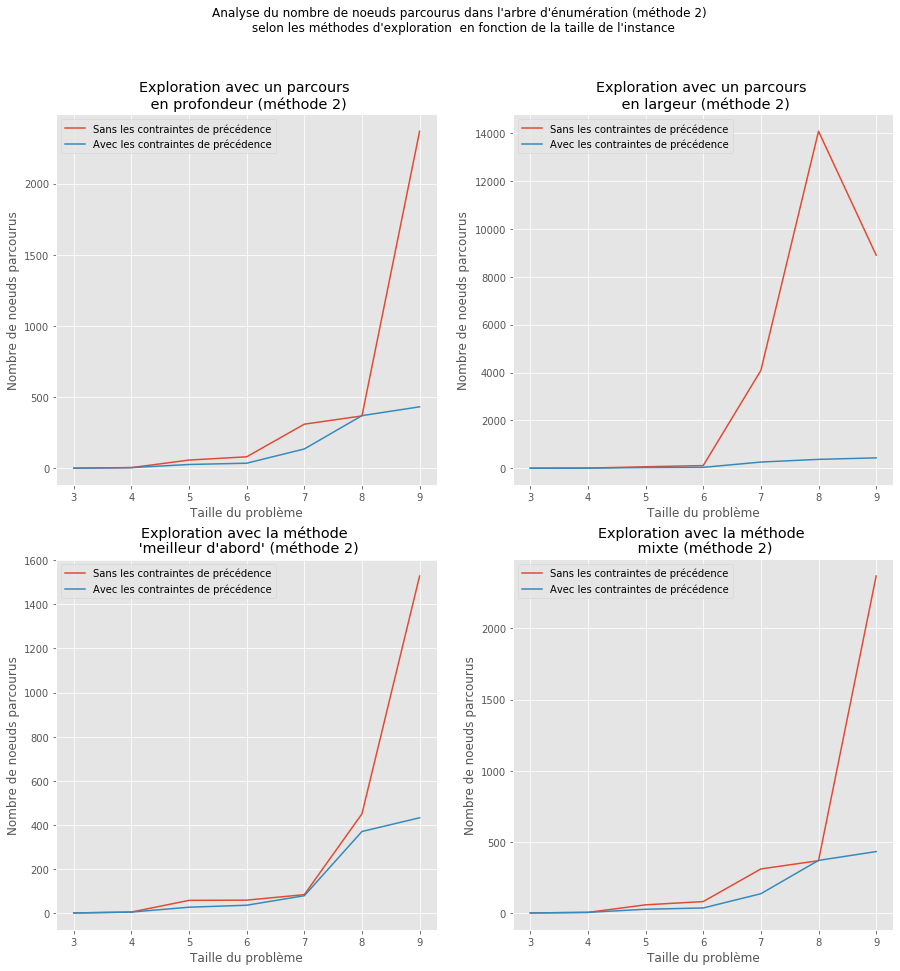

In [114]:
#différentes tailles d'instance pour les tests
val=[i for i in range(3,10)]

#liste pour sauvegarder tps d'execution et nb iterations
#Sans contraintes de précédence:
t_m2_dfs = [] ; t_m2_bfs = [] ; t_m2_best = [] ; t_m2_mixed = []
#Avec contraintes de précédence:
t_m2_dfs_pred = [] ; t_m2_bfs_pred = [] ; t_m2_best_pred = [] ; t_m2_mixed_pred = []


for n in val:
    print("Traitement problème taille:",n)
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,depth_first_method)
    t_m2_dfs.append([time.time()-t1_bb1,k1])


    #Méthode 1 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,breadth_first_method)
    t_m2_bfs.append([time.time()-t1_bb2,k2])


    #Méthode 1 avec la méthode "meilleur d'abord":
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,best_first_method)
    t_m2_best.append([time.time()-t1_bb3,k3])


    #Méthode 1 avec la méthode "mixte":
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,mixed_method)
    t_m2_mixed.append([time.time()-t1_bb4,k4])
    
    #Ajout d'une contrainte de précédence: la pièce 0 doit passer en dernier
    probleme.ajouterContraintePrecedence(0,list(range(2,n)))
    probleme.ajouterContraintePrecedence(1,list(range(2,n)))
    for p in range(2,n-1):
        probleme.ajouterContraintePrecedence(p,[n-2,n-1])
    
    #Méthode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2_pred,depth_first_method)
    t_m2_dfs_pred.append([time.time()-t1_bb1,k1])


    #Méthode 1 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2_pred,breadth_first_method)
    t_m2_bfs_pred.append([time.time()-t1_bb2,k2])


    #Méthode 1 avec la méthode "meilleur d'abord":
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2_pred,best_first_method)
    t_m2_best_pred.append([time.time()-t1_bb3,k3])


    #Méthode 1 avec la méthode "mixte":
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2_pred,mixed_method)
    t_m2_mixed_pred.append([time.time()-t1_bb4,k4])

#affichage resultats
fig, axs = plt.subplots(2,2,figsize=(15, 15))
plt.suptitle("Analyse du nombre de noeuds parcourus dans l'arbre d'énumération (méthode 2) \n selon les méthodes d'exploration  en fonction de la taille de l'instance")

label=["Sans les contraintes de précédence","Avec les contraintes de précédence"]

axs[0,0].set_title("Exploration avec un parcours \n en profondeur (méthode 2)")
for (t,l) in zip([t_m2_dfs,t_m2_dfs_pred],label):
    axs[0,0].plot(val,[z[1] for z in t],label=l)
axs[0,0].set_ylabel("Nombre de noeuds parcourus")
axs[0,0].set_xlabel("Taille du problème")
axs[0,0].legend()
    
axs[0,1].set_title("Exploration avec un parcours \n en largeur (méthode 2)")
for (t,l) in zip([t_m2_bfs,t_m2_bfs_pred],label):
    axs[0,1].plot(val,[z[1] for z in t],label=l)
axs[0,1].set_ylabel("Nombre de noeuds parcourus")
axs[0,1].set_xlabel("Taille du problème")
axs[0,1].legend()

axs[1,0].set_title("Exploration avec la méthode \n 'meilleur d'abord' (méthode 2)")
for (t,l) in zip([t_m2_best,t_m2_best_pred],label):
    axs[1,0].plot(val,[z[1] for z in t],label=l)
axs[1,0].set_ylabel("Nombre de noeuds parcourus")
axs[1,0].set_xlabel("Taille du problème")
axs[1,0].legend()
    
axs[1,1].set_title("Exploration avec la méthode \n mixte (méthode 2)")
for (t,l) in zip([t_m2_mixed,t_m2_mixed_pred],label):
    axs[1,1].plot(val,[z[1] for z in t],label=l)
axs[1,1].set_ylabel("Nombre de noeuds parcourus")
axs[1,1].set_xlabel("Taille du problème")
axs[1,1].legend()

plt.show()

On remarque bien que le nombre de noeuds parcourus dans l'algorithme est plus faible lorsque l'on ajoute des contraintes de précédence et ceci d'autant plus que la taille de l'instance à traiter augmente. Ceci vérifie bien numériquement ce que nous avons supposé plus haut.

## Conclusion 

    TO DO